**Advanced Statistics. [Assignment #2](https://hackmd.io/s/r1WGbzm6Q)**: Application of Sampling

*Ilya Borovik, BS4-DS* (i.borovik@innopolis.ru)

# Preparation

In [1]:
import numpy as np
import pandas as pd

from geopy.distance import great_circle
import json

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

import warnings
warnings.filterwarnings("ignore")

N_CITIES = 30
RANDOM_SEED = 3
DATA_DIR = 'data/'
RESULTS_DIR = 'results/'

# Simulated Annealing for continuous function

Implementing and testing Simulated Annealing together with Pyplot animations on the example from the [task](https://hackmd.io/s/r1WGbzm6Q).

In [2]:
def p(E_x, T=1.0):
    return np.exp(-E_x / T)

def simulated_annealing(E, x_0=0., T_0=3.0, T_cool=1e-3, ann_rate=0.97):
        """
        Simulated Annealing for a given continuous Energy distribution.

        :param: E:        energy distribution function
        :param: x_0:      initial solution
        :param: T_0:      initial temperature
        :param: T_cool:   minimal possible temperature
        :param: ann_rate: annealing rate
        :return:         lists of all intermediate solutions and temperatures
        """
    x_t, T = x_0, T_0
    xs, Ts = [x_t], [T]
    
    while T > T_cool:
        x_n = x_t + np.random.uniform(-1, 1)
  
        if np.random.uniform(0, 1) <= p(E(x_n), T) / p(E(x_t), T):
            x_t = x_n
        
        xs.append(x_t)
        Ts.append(T)
        T *= ann_rate
    
    return np.array(xs), np.array(Ts)

In [3]:
w = np.array([0.13511111, 0.30565641, 0.85789735, 0.19849365, 0.0972464 ])
phi = np.array([0.76633178, 0.07614028, 0.57433697, 2.05374239, 1.97379992])
a = np.array([12.80479424,  1.57398667,  1.46134803,  4.93294448,  4.12038971])
h = np.vectorize(lambda x: sum(np.cos(x * a + phi) * w))

np.random.seed(23)
xs, Ts = simulated_annealing(h, ann_rate=0.98)

<IPython.core.display.Javascript object>


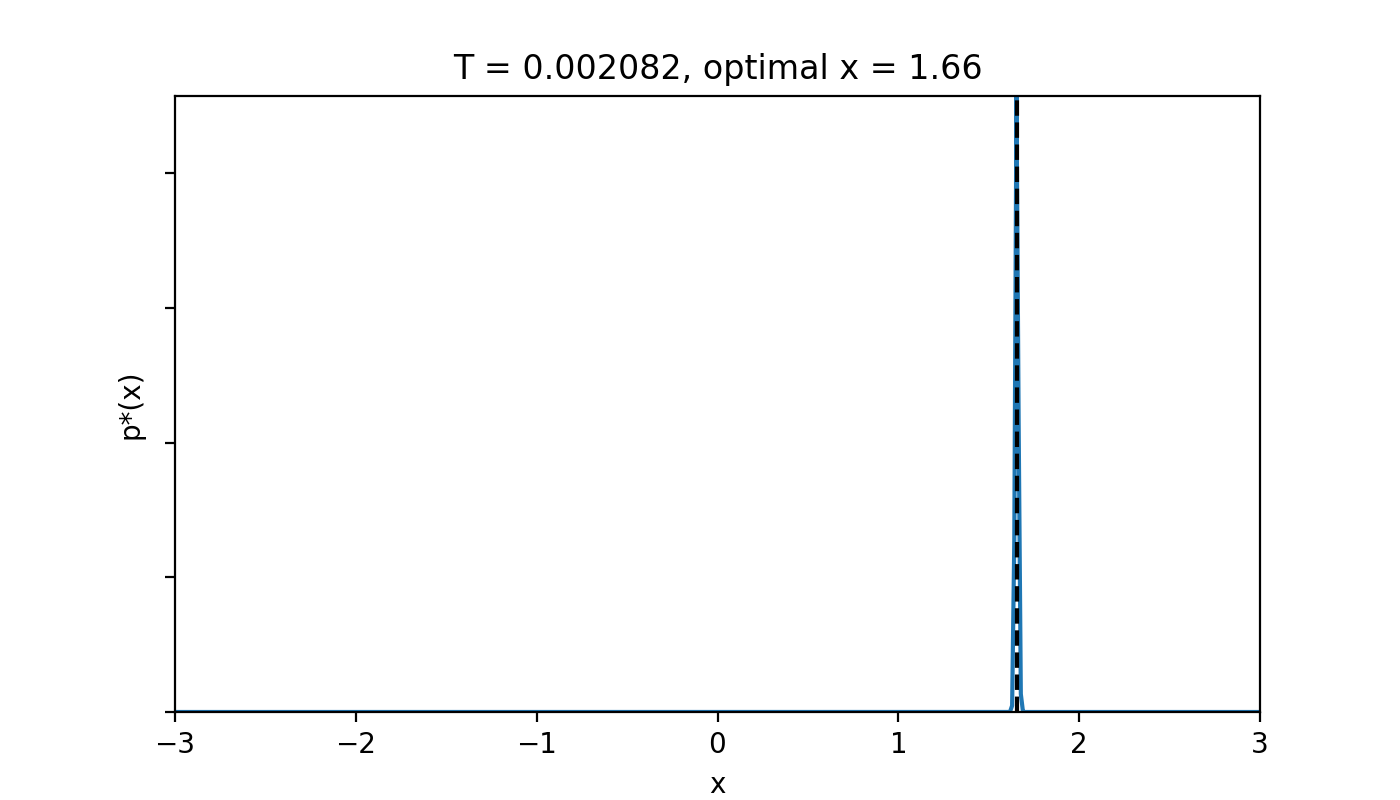

In [4]:
class SAAnim(object):
    """ Class for the animations """
    def __init__(self, ax, xs, Ts):
        self.xs = xs
        self.Ts = Ts

        # plot main elemnets
        self.ax = ax
        self.x = np.linspace(-3., 3., 500)
        self.line_e, = ax.plot(self.x, p(h(self.x), T=Ts[0]))
        self.line_x = ax.axvline(x=2., color='black', linestyle='--')
        self.set_title(self.Ts[0], self.xs[0])
        
        # plot parameters
        self.ax.set_xlim(-3, 3)
        self.ax.set_yticklabels([])
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('p*(x)')
        
    def init(self):
        """ Initial plot """
        self.line_e.set_ydata([np.nan] * len(self.x))
        self.line_x.set_xdata(2.)
        self.set_title(self.Ts[0], self.xs[0])
        return self.line_e, self.line_x,
    
    def set_title(self, T, x):
        self.ax.set_title(f'T = {T:.6f}, optimal x = {x:.2f}')

    def __call__(self, i):
        if i == 0:
            return self.init()
        
        if i < len(self.xs):
            y_data = p(h(self.x), T=self.Ts[i])
            self.ax.set_ylim(np.min(y_data), np.max(y_data))
            self.line_e.set_data(self.x, y_data)
            
            if self.xs[i] != self.xs[i-1]:
                self.line_x.set_xdata(self.xs[i])
            
            self.set_title(self.Ts[i], self.xs[i])
        
        return self.line_e, self.line_x,

fig, ax = plt.subplots(figsize=(7,4))
sa_anim = SAAnim(ax, xs, Ts)
anim = FuncAnimation(fig, sa_anim, init_func=sa_anim.init,
                     interval=1, blit=True)
plt.show()

# Traveling Salesman problem

Implementing and running SA on the Russian cities dataset to find the shortest path that visits the 30 most popular by population cities.

## Dataset

### Cities

Loading cities dataset, preprocessing, extracting top 30 cities, computing distance matrix between cities.

In [5]:
df = pd.read_csv(DATA_DIR + 'cities.csv')
df.head()

Индекс Тип региона     Регион Тип района Район Тип города          Город  \
0  385200.0        Респ     Адыгея        NaN   NaN          г       Адыгейск   
1  385000.0        Респ     Адыгея        NaN   NaN          г         Майкоп   
2  649000.0        Респ      Алтай        NaN   NaN          г  Горно-Алтайск   
3  658125.0        край  Алтайский        NaN   NaN          г         Алейск   
4  656000.0        край  Алтайский        NaN   NaN          г        Барнаул   

  Тип н/п  Н/п      Код КЛАДР    ...    Уровень по ФИАС  \
0     NaN  NaN   100000200000    ...           4: город   
1     NaN  NaN   100000100000    ...           4: город   
2     NaN  NaN   400000100000    ...           4: город   
3     NaN  NaN  2200000200000    ...           4: город   
4     NaN  NaN  2200000100000    ...           4: город   

  Признак центра района или региона    Код ОКАТО     Код ОКТМО  Код ИФНС  \
0                                 0  79403000000  7.970300e+10       107   
1                                 2  79401000000  7.970100e+10       105   
2                                 2  84401000000  8.470100e+07       400   
3                                 0   1403000000  1.703000e+06      2201   
4                                 2   1401000000  1.701000e+06      2200   

   Часовой пояс     Широта    Долгота  Федеральный округ Население  
0         UTC+3  44.878372  39.190172              Южный     12689  
1         UTC+3  44.609827  40.100653              Южный    144055  
2         UTC+7  51.958268  85.960296          Сибирский     62861  
3         UTC+7  52.492091  82.779415          Сибирский     28528  
4         UTC+7  53.348115  83.779836          Сибирский    635585  

[5 rows x 21 columns]

In [6]:
# needed columns
columns = ['Город', 'Регион', 'Долгота', 'Широта', 'Население']
df = df[columns]

# fixing invalid value and converting population to int
df = df[df['Население'] != '96[3]']
df['Население'] = df['Население'].astype(int)

# fixing NaN values in City name
df['Город'].fillna(value=df['Регион'], inplace=True)

In [7]:
cities = df.sort_values(ascending=False, by=['Население'])[:N_CITIES]
cities

Город           Регион     Долгота     Широта  Население
506            Москва           Москва   37.620373  55.753879   11514330
782   Санкт-Петербург  Санкт-Петербург   30.315822  59.939125    4848742
643       Новосибирск    Новосибирская   82.921057  55.028102    1498921
828      Екатеринбург     Свердловская   60.605489  56.838633    1377738
615   Нижний Новгород    Нижегородская   44.005395  56.324209    1250615
924            Казань        Татарстан   49.111531  55.794388    1216965
778            Самара        Самарская   50.106769  53.195166    1164900
652              Омск           Омская   73.367464  54.984814    1154000
1060        Челябинск      Челябинская   61.400786  55.160366    1130273
753    Ростов-на-Дону       Ростовская   39.718787  47.222436    1091544
62                Уфа     Башкортостан   55.957865  54.734853    1062300
121         Волгоград    Волгоградская   44.517021  48.707200    1021244
702             Пермь         Пермский   56.234178  58.010321    1000679
410        Красноярск     Красноярский   92.852416  56.009466     973826
159           Воронеж      Воронежская   39.196828  51.659238     889680
797           Саратов      Саратовская   45.953026  51.530376     836900
380         Краснодар    Краснодарский   38.976080  45.040235     744933
780          Тольятти        Самарская   49.389461  53.520644     719484
4             Барнаул        Алтайский   83.779836  53.348115     635585
995            Ижевск       Удмуртская   53.211396  56.852744     628117
1004        Ульяновск      Ульяновская   48.374872  54.308067     613793
713       Владивосток       Приморский  131.882348  43.116381     592069
1111        Ярославль      Ярославская   39.897878  57.621614     591486
222           Иркутск        Иркутская  104.280655  52.286351     587225
991            Тюмень        Тюменская   65.534312  57.153082     581758
177         Махачкала         Дагестан   47.504630  42.984857     577990
1011        Хабаровск      Хабаровский  135.059881  48.464799     577668
662          Оренбург     Оренбургская   55.101738  51.787519     570329
321       Новокузнецк      Кемеровская   87.214405  53.794276     547885
315          Кемерово      Кемеровская   86.046786  55.390972     532884

Computing distance matrix for all pairs of cities

In [8]:
coords = cities[['Широта', 'Долгота']].values
dist_m = np.array([[great_circle(ci, cj).km for ci in coords] for cj in coords])
dist_m.shape

(30, 30)

### Country outline

Loading country outline and taking only polygons with positive longitude.

In [9]:
with open(DATA_DIR + 'russia.json') as f:
    geojson = json.load(f)

rus_data = geojson[0]['geojson']['coordinates'][4:] # taking only data with positive longitude

## Plot functions

Defining plot functions for the cities, country outline, paths and SA convergence rates.

In [10]:
def plot_cities(ax, cities, name_size=8, name_len=None):
    cities.plot.scatter(
        ax=ax, x='Долгота', y='Широта',
        s=cities['Население']/75000, label='Население', 
        alpha=0.6,
    )   
    for i, txt in enumerate(cities['Город']):
        if name_len:
            ax.annotate(txt[:name_len], (cities['Долгота'].iloc[i], cities['Широта'].iloc[i]), size=name_size)
        else:
            ax.annotate(txt, (cities['Долгота'].iloc[i], cities['Широта'].iloc[i]), size=name_size)
    ax.legend()

def plot_country(ax, rus_data, color='C0', alpha=0.7):
    for patch in rus_data:
        patch_coord = np.array(patch)[0]
        ax.plot(patch_coord[:, 0], patch_coord[:, 1], color=color, alpha=alpha)
    ax.set_xlim(20, 180)
    ax.set_ylim(40, None)
        
def plot_path(ax, coords, path, color='C0', linewidth=1.5, alpha=0.7):
    path_coord = coords[np.concatenate([path, [path[0]]])]
    ax.plot(path_coord[:, 1], path_coord[:, 0], color=color, linewidth=linewidth, alpha=alpha)
    
def plot_temp_dist(ax, Ts, ds, ann_rate):
    t = np.arange(len(ds))
    
    color = 'tab:red'
    ax.set_xlabel('iterations')
    ax.set_ylabel('temperature', color=color)
    ax.plot(t, Ts, color=color, alpha=0.6)
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_title(f'Convergence of SA (ann_rate = {ann_rate})')
    
    ax_d = ax.twinx()
    color = 'tab:blue'
    ax_d.set_ylabel('distance', color=color)
    ax_d.plot(t, ds, color=color, alpha=0.9)
    ax_d.tick_params(axis='y', labelcolor=color)

Plotting cities

<IPython.core.display.Javascript object>


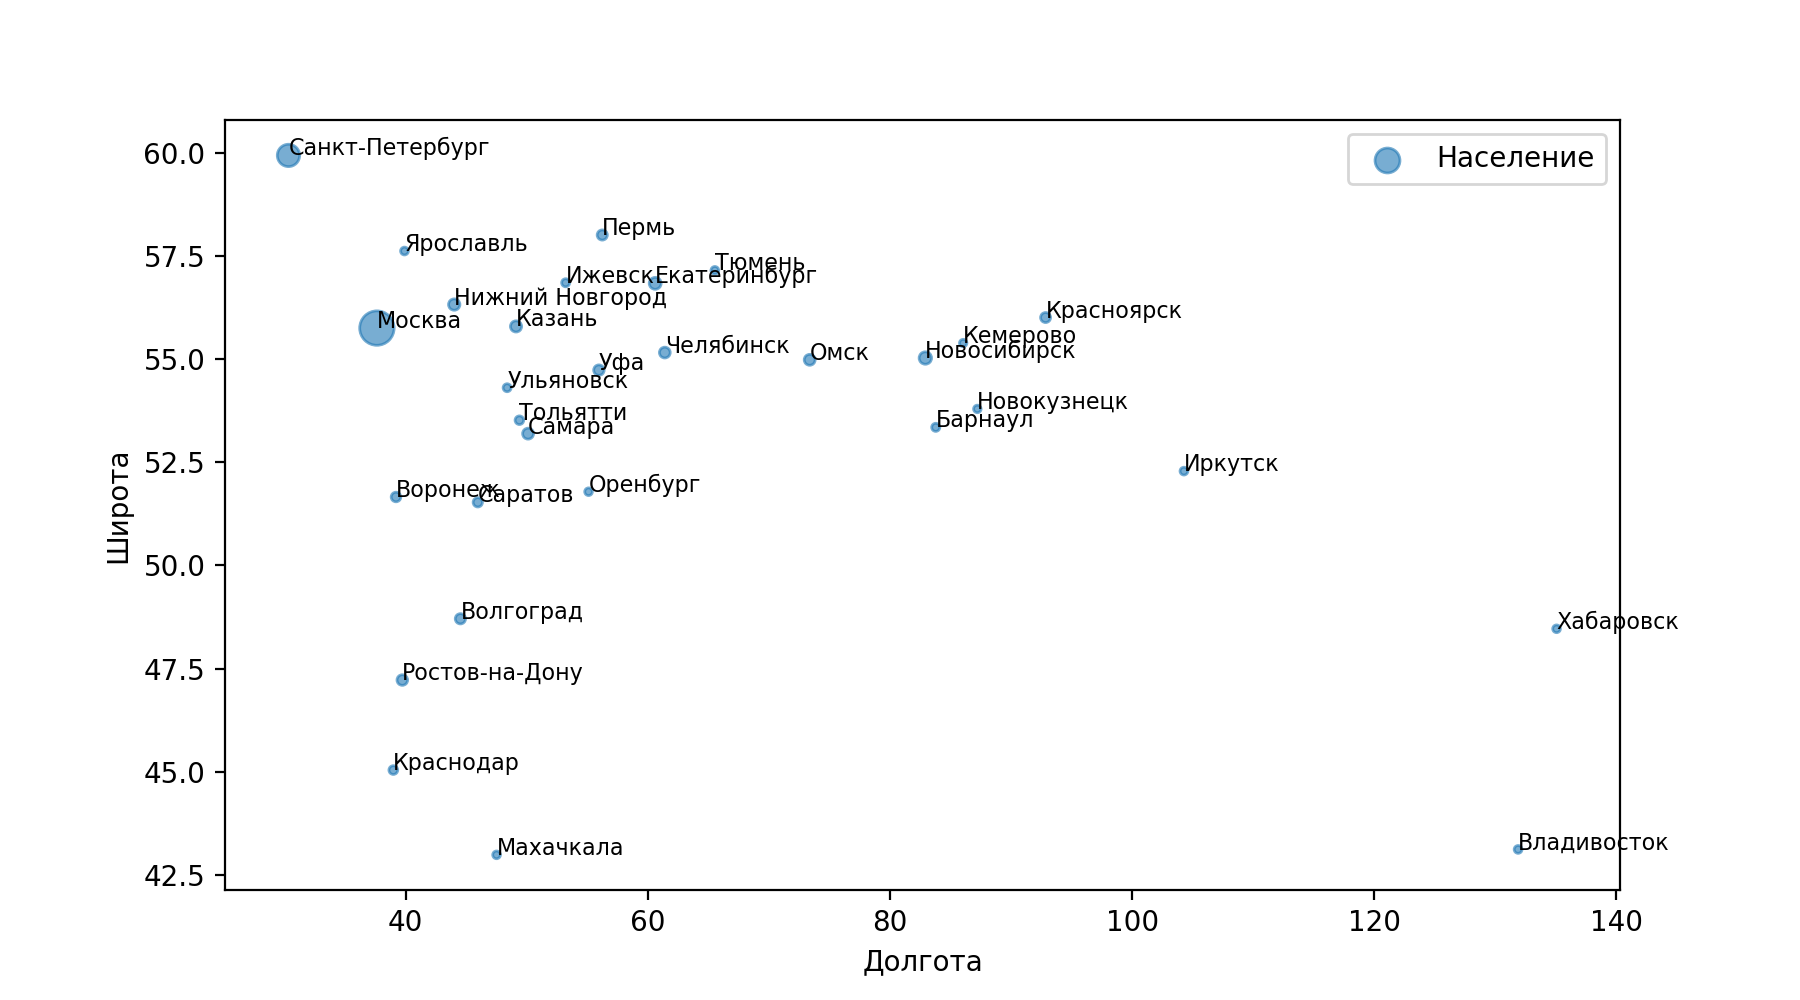

In [11]:
fig, ax = plt.subplots(figsize=(9,5))
plot_cities(ax, cities)

Adding country outline

<IPython.core.display.Javascript object>


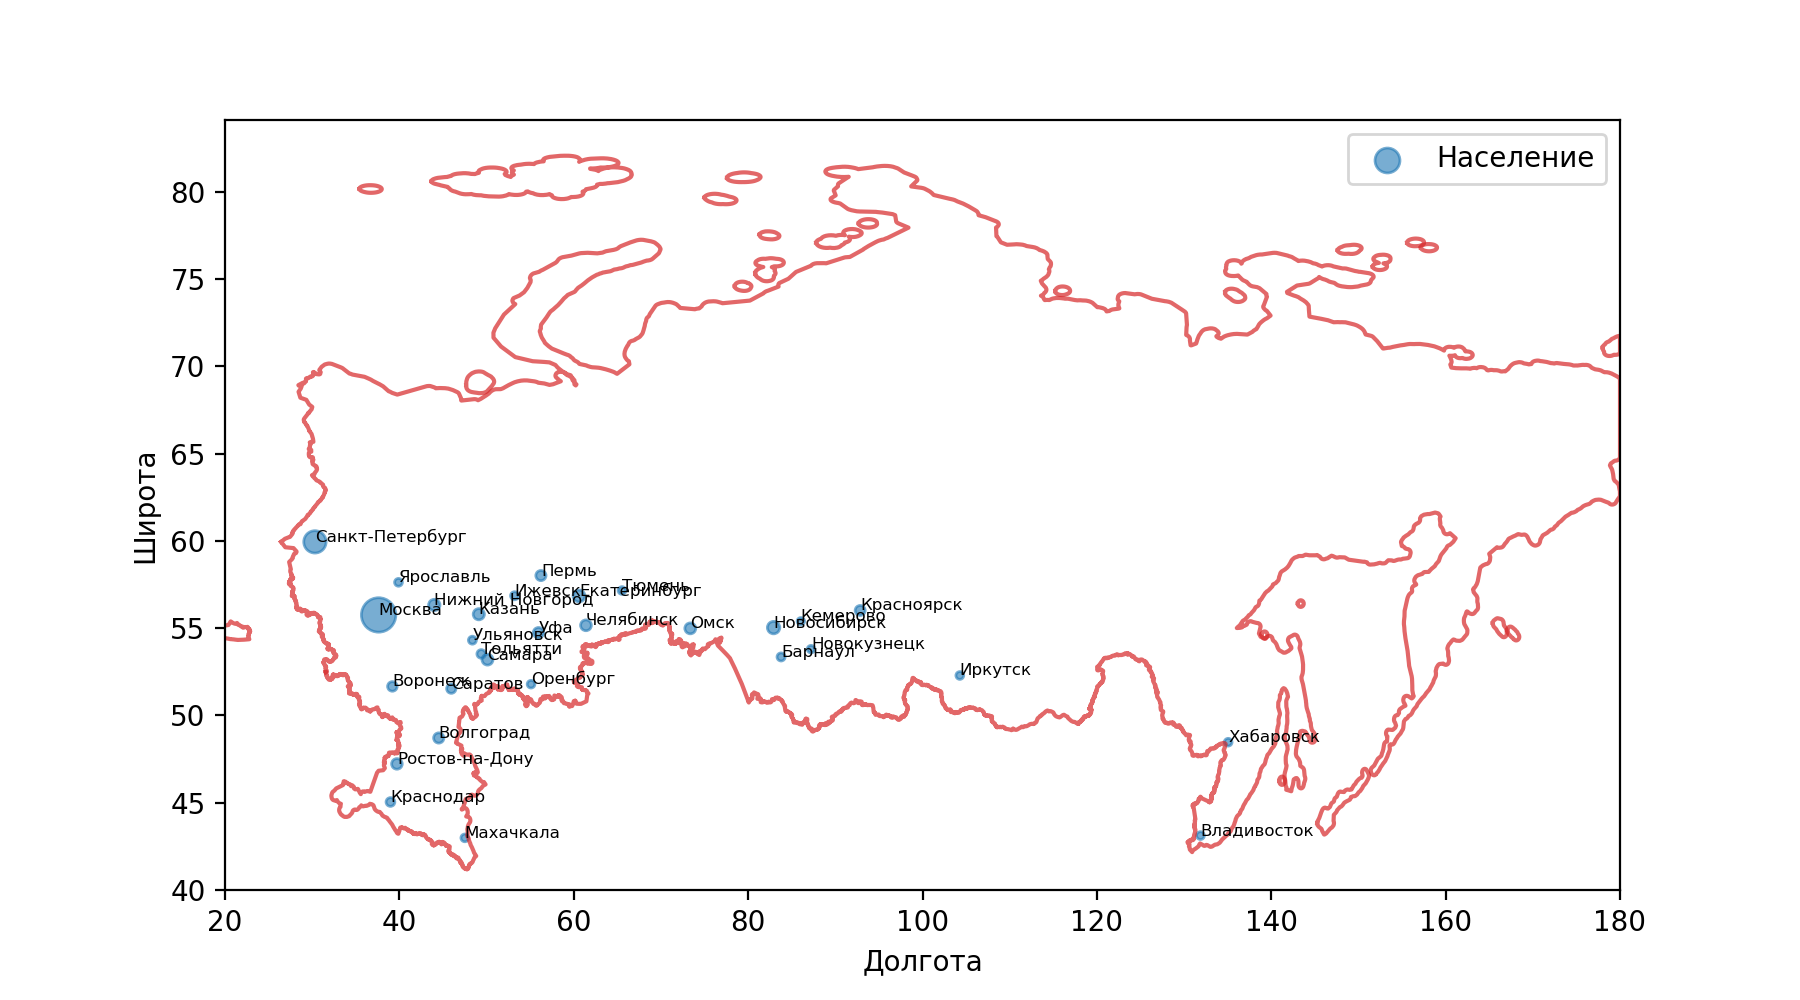

In [12]:
fig, ax = plt.subplots(figsize=(9,5))
plot_country(ax, rus_data, color='C3')
plot_cities(ax, cities, name_size=6)

Defining initial path for all search runs and showing it on a graph

<IPython.core.display.Javascript object>


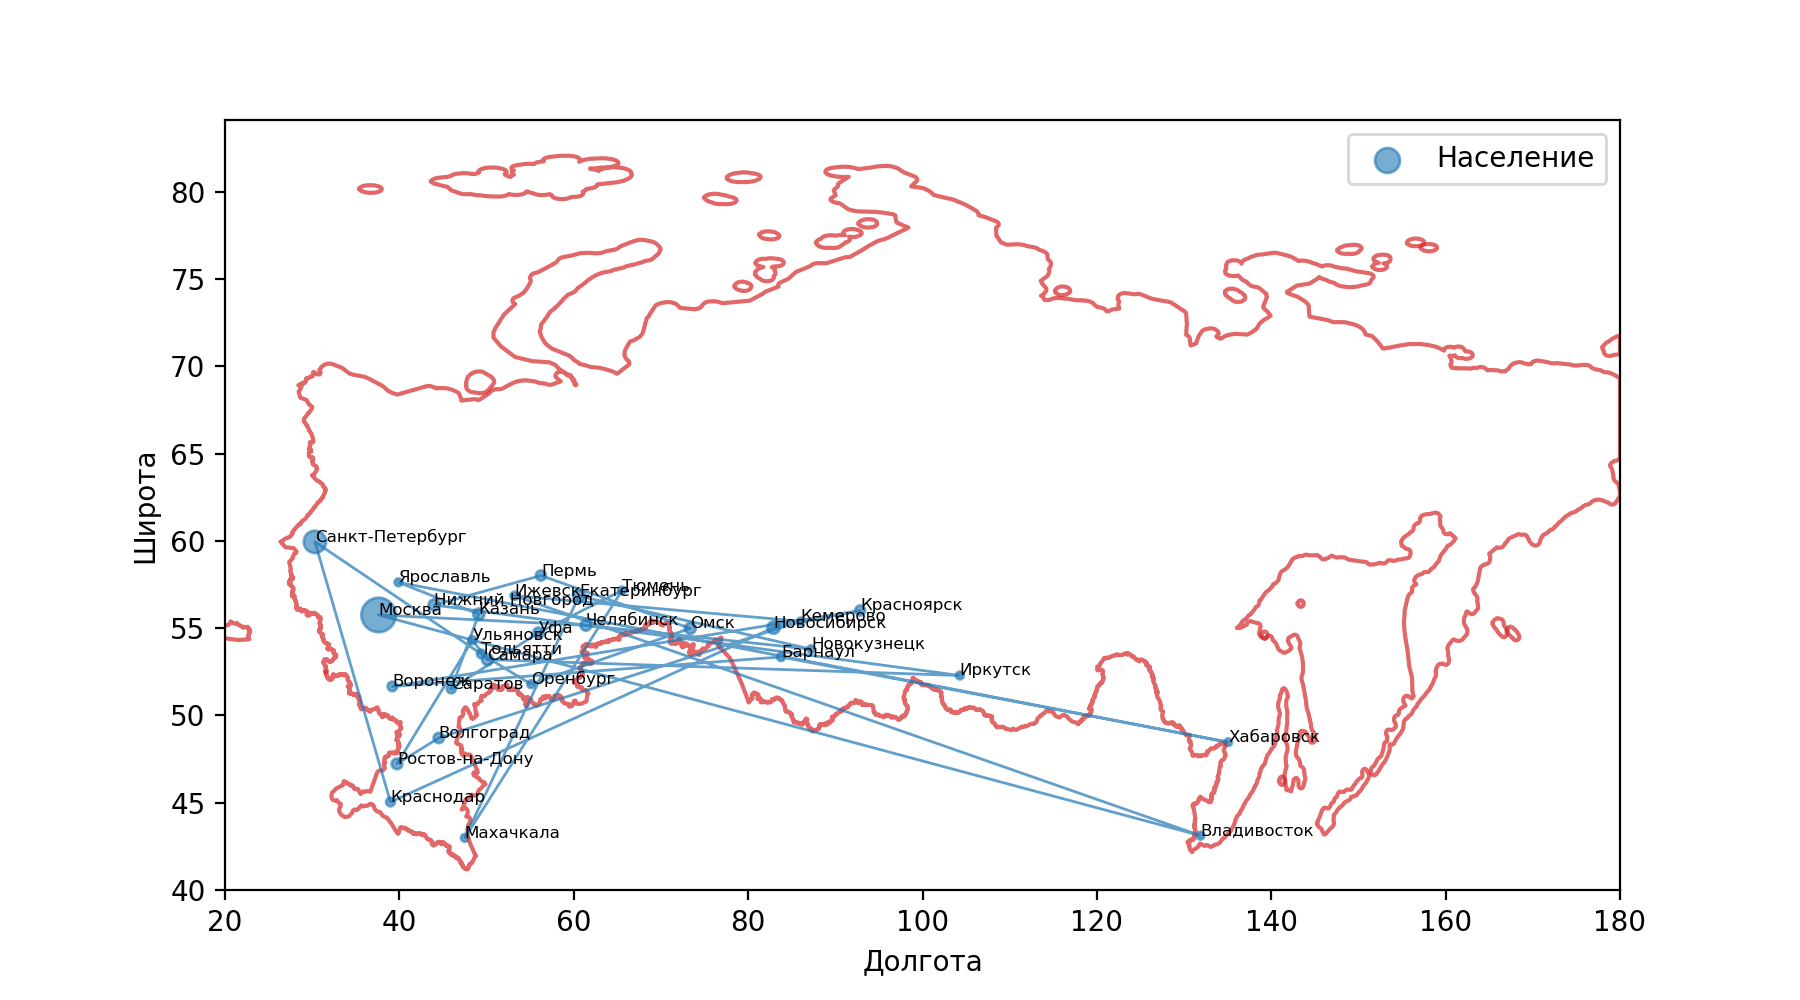

In [13]:
np.random.seed(RANDOM_SEED)
path = np.arange(N_CITIES)
np.random.shuffle(path)

fig, ax = plt.subplots(figsize=(9,5))
plot_cities(ax, cities, name_size=6)
plot_country(ax, rus_data, color='C3')
plot_path(ax, coords, path, linewidth=1.)
plt.show()

## Utility functions and classes

### Distances and city exchange

* Function that exchanges two cities in the path
* Energy function for the problem
* Function that computes differences in distance between the path $p_t$ and path $p_{t+1}$ constructed by exchanged two cities in path $p_t$

The latter function makes it possible to reduce computational complexity for the calculation of distance of the new path from `O(N)` to `O(1)`, where `N` is the number of cities.

In [14]:
def exchange_cities(path, i, j):
    c = path[i]
    path[i], path[j] = path[j], c
    return path

def path_dist(path, dist_m):
    res = dist_m[path[-1]][path[0]]
    for i in range(len(path) - 1):
        res += dist_m[path[i]][path[i+1]]
    return res

def path_dist_diff(path, dist_m, i, j):
    diff = -dist_m[path[i]][path[i-1]] if i != 0 else 0
    diff -= dist_m[path[i]][path[i+1]]
    diff -= dist_m[path[j]][path[j-1]]
    diff -= dist_m[path[j]][path[j+1]] if j != len(path) - 1 else 0
    diff -= dist_m[path[0]][path[-1]] if i == 0 or j == len(path) - 1 else 0
    
    path = exchange_cities(path, i, j)
    
    diff += dist_m[path[i]][path[i-1]] if i != 0 else 0
    diff += dist_m[path[i]][path[i+1]]
    diff += dist_m[path[j]][path[j-1]]
    diff += dist_m[path[j]][path[j+1]] if j != len(path) - 1 else 0
    diff += dist_m[path[0]][path[-1]] if i == 0 or j == len(path) - 1 else 0
    
    # exchanging back
    path = exchange_cities(path, i, j)
    
    return diff

Testing the difference function. Values should be the same.

In [15]:
np.random.seed(RANDOM_SEED)
path = np.arange(N_CITIES)
np.random.shuffle(path)

d_path_0 = path_dist(path, dist_m)

for i, j in [(0, 29), (5, 13), (0, 3), (14, 29), (25, 26)]:
    path = exchange_cities(path, i, j)
    d_path_1 = path_dist(path, dist_m)
    path = exchange_cities(path, i, j)

    print(i, j, d_path_0 + path_dist_diff(path, dist_m, i, j), d_path_1)
    assert abs(d_path_0 + path_dist_diff(path, dist_m, i, j) - d_path_1) < 1e-8

0 29 64098.719463920504 64098.719463920504
5 13 61986.32076036358 61986.320760363575
0 3 66749.24827007172 66749.24827007171
14 29 62800.96983895968 62800.96983895967
25 26 63262.318465752374 63262.318465752374


### Animation Class

In [16]:
class CitySAAnim(object):
    """ Animation of SA for the Traveling Salesman problem. """
    def __init__(self, ax, xs, ds, Ts, ann_rate, cities=cities, country=None):
        """
        Initialization.
        
        :param: ax:        plot axis
        :param: xs:        a list of paths
        :param: ds:        a list of path distances
        :param: Ts:        a list of temperatures
        :param: ann_rate:  annealing rate (for the plot title)
        :param: cities:    cities dataframe
        :param: country:   country multipolygon data (if None, country outline is not shown)
        """
        self.xs = xs
        self.ds = ds
        self.Ts = Ts
        self.ann_rate = ann_rate
        self.cities = cities
        self.coords = self.cities[['Широта', 'Долгота']].values

        self.ax = ax
        
        # defining parameters depending on the presence of country outline
        if country:
            plot_country(ax, country, color='C3')
            plot_cities(self.ax, self.cities, name_size=6)
            self.path_lw = 1.
        else:
            plot_cities(self.ax, self.cities)
            self.path_lw = 1.5
        
        self.path = plot_path(self.ax, self.coords, self.xs[0], linewidth=self.path_lw)
        self.set_title(self.Ts[0], self.ds[0])
        
    def init(self):
        """ Initial frame """
        self.ax.lines[-1].remove()
        self.path = plot_path(self.ax, self.coords, self.xs[0], linewidth=self.path_lw)
        self.set_title(self.Ts[0], self.ds[0])
        return self.path,
    
    def set_title(self, T, d):
        """ Title of the plot """
        self.ax.set_title(f'ann_rate = {self.ann_rate}, T = {T:.6f}, optimal dist = {d:.2f} km')

    def __call__(self, i):
        """ Frame update """
        if i == 0:
            return self.init()
        
        if i < len(self.xs):
            if not np.array_equal(self.xs[i], self.xs[i-1]):
                # updating path only if it differs from the previously plotted
                self.ax.lines[-1].remove()
                self.path = plot_path(self.ax, self.coords, self.xs[i], linewidth=self.path_lw)
            if self.Ts[i] != self.Ts[i-1] or self.ds[i] != self.ds[i-1]:
                # updating title only if it differs from the previous title
                self.set_title(self.Ts[i], self.ds[i])

        return self.path,

## Simulated Annealing

In [17]:
def p(E_x, T=1.0):
    return np.exp(-E_x / T)

def comb_simulated_annealing(x_0, T_0=1000.0, T_cool=1., ann_rate=0.95, ann_n_iter=4):
    """
    Simulated Annealing for The Traveling Salesman problem.
    
    :param: x_0:        initial path
    :param: T_0:        initial temperature
    :param: T_cool:     minimal possible temperature
    :param: ann_rate:   annealing rate
    :param: ann_n_iter: after how many iterations temperature should be cooled down
    :return:            lists of all intermediate paths, their distances and SA temperatures
    """
    
    t, x_t, T = 0, x_0, T_0
    dist_t = path_dist(x_t, dist_m)
    xs, ds, Ts = [x_t.copy()], [dist_t], [T]
    
    while T > T_cool:
        t += 1
        
        # generating a pair of different indices
        i = j = 0
        while i == j:
            i, j = sorted(np.random.randint(low=0, high=N_CITIES, size=2))
            
        # distance of new path and acceptance ratio
        dist_n = dist_t + path_dist_diff(x_t, dist_m, i, j)
        alpha = p(dist_n, T) / p(dist_t, T)

        if np.isnan(alpha):
            # helping SA in delaing with arithmetic overflows
            # sampling indices that may produce non-nan alpha and choosing a random pair
            
            possible_exch = []
            for i in range(dist_m.shape[0]):
                for j in range(i+1, dist_m.shape[0]):
                    dist_n = dist_t + path_dist_diff(x_t, dist_m, i, j)
                    if not np.isnan(p(dist_n, T) / p(dist_t, T)):
                        possible_exch.append((i, j))
            
            if possible_exch:
                i, j = possible_exch[np.random.randint(low=0, high=len(possible_exch))]
            else:
                # all values are nan, finish early
                break
    
            # pair of indices with non-nan energy
            dist_n = dist_t + path_dist_diff(x_t, dist_m, i, j)
            alpha = p(dist_n, T) / p(dist_t, T)
        
        if np.random.uniform(0, 1) <= alpha:
            # accepting new path
            dist_t = dist_n
            x_t = exchange_cities(x_t, i, j)
        
        xs.append(x_t.copy())
        ds.append(dist_t)
        Ts.append(T)
        
        if t % ann_n_iter == 0:
            # cooling temoerature down
            T *= ann_rate

    return np.array(xs), np.array(ds), np.array(Ts)

Fixing some parameters in functions

In [18]:
from functools import partial

comb_sa = partial(comb_simulated_annealing, T_0=4e3, ann_n_iter=4)

### Fast Coolling – `ann_rate = 0.9`

Running Simulated Annealing, checking convergence and showing computed optimal result.

In [19]:
np.random.seed(RANDOM_SEED)
path = np.arange(N_CITIES)
np.random.shuffle(path)

ann_rate = 0.9
xs_09, ds_09, Ts_09 = comb_sa(path, ann_rate=ann_rate)

xs, ds, Ts = xs_09.copy(), ds_09.copy(), Ts_09.copy()
len(ds), ds[-1], Ts[-1]

(177, 31722.876266465337, 43.101054657223315)

<IPython.core.display.Javascript object>


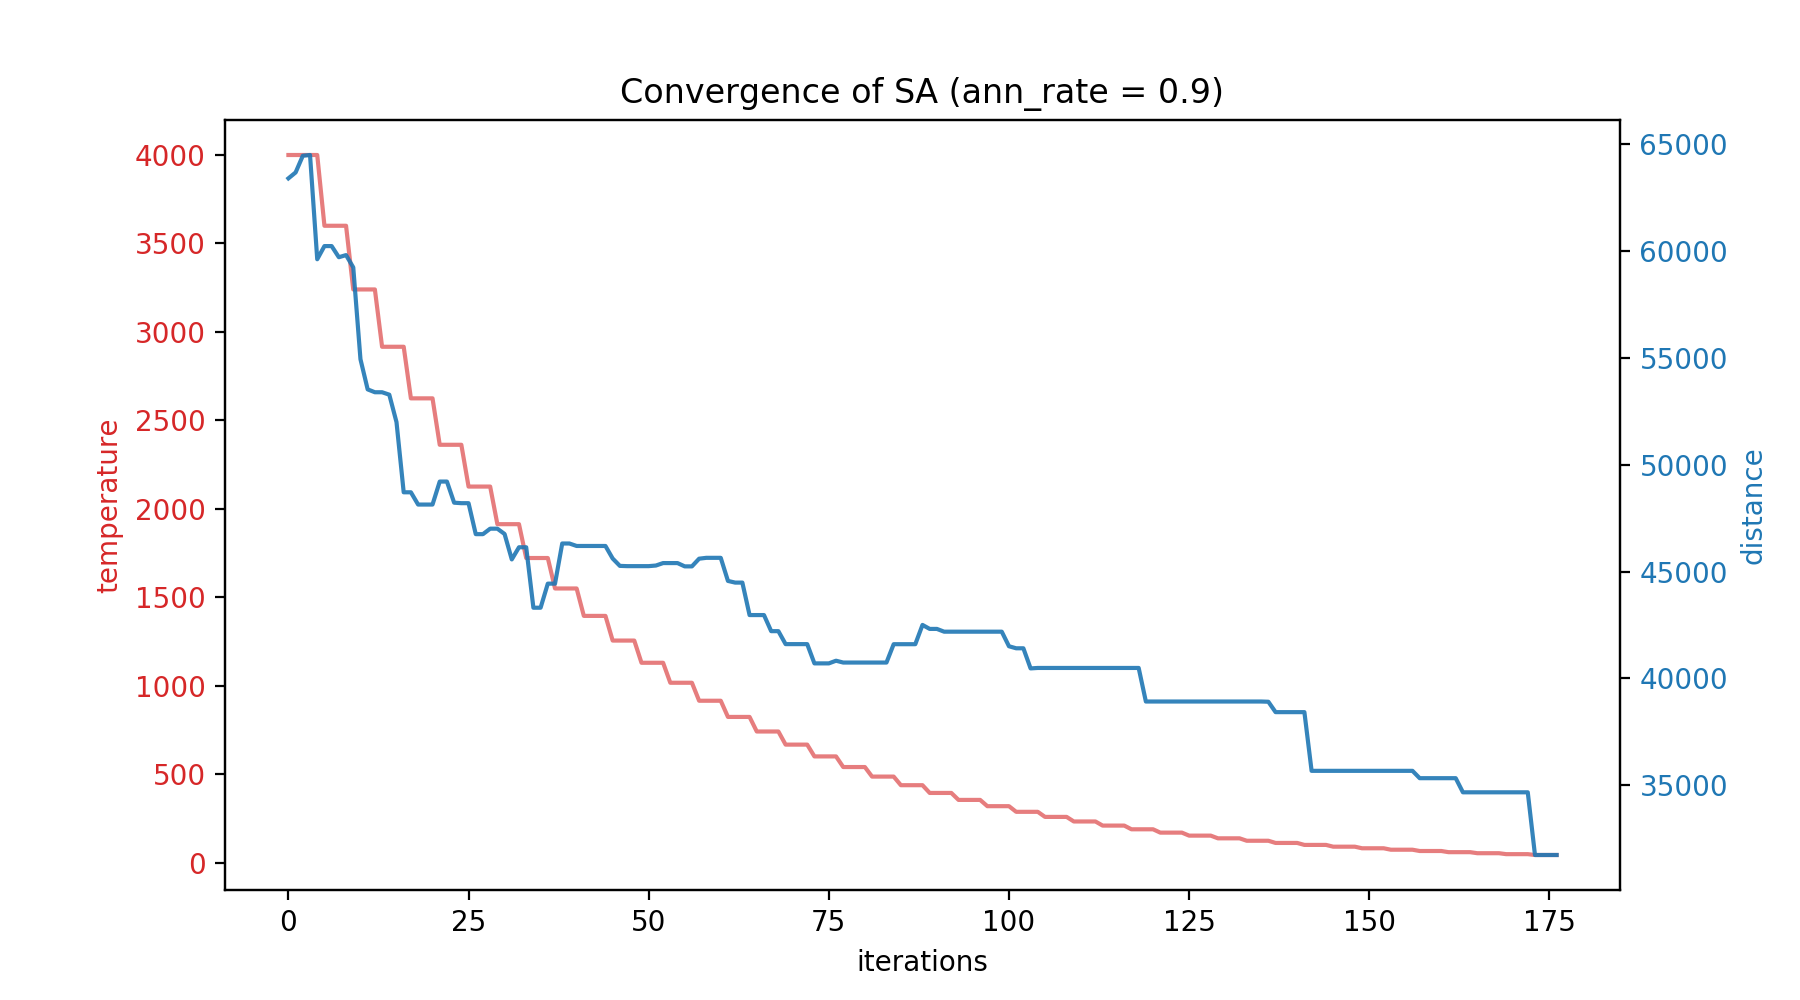

In [20]:
fig, ax = plt.subplots(figsize=(9,5))
plot_temp_dist(ax, Ts, ds, ann_rate=ann_rate)
plt.show()

<IPython.core.display.Javascript object>


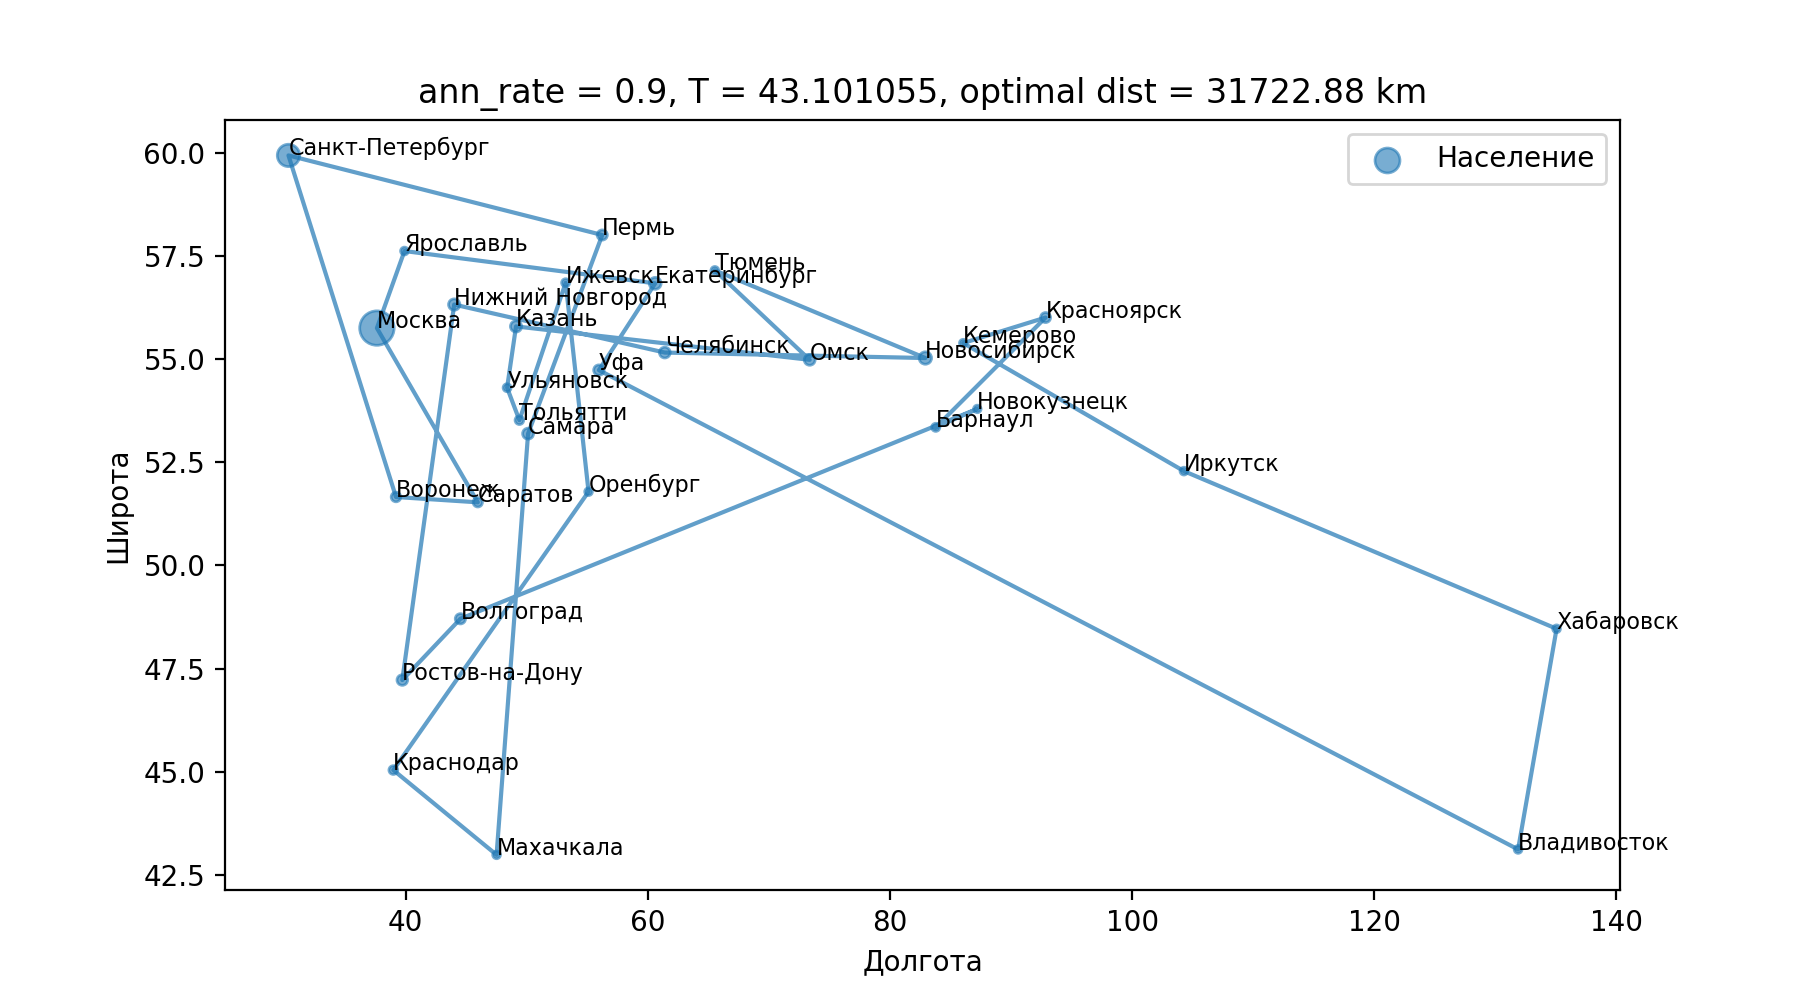

In [21]:
fig, ax = plt.subplots(figsize=(9,5))
sa_anim = CitySAAnim(ax, xs, ds, Ts, ann_rate)
anim = FuncAnimation(fig, sa_anim, init_func=sa_anim.init, 
                     frames=len(ds), repeat=False,
                     save_count=1, interval=1, blit=False)

plt.show()

In [22]:
writer = FFMpegWriter(fps=40, bitrate=None)
anim.save(RESULTS_DIR + 'fast_09.mp4', writer=writer)

<IPython.core.display.Javascript object>


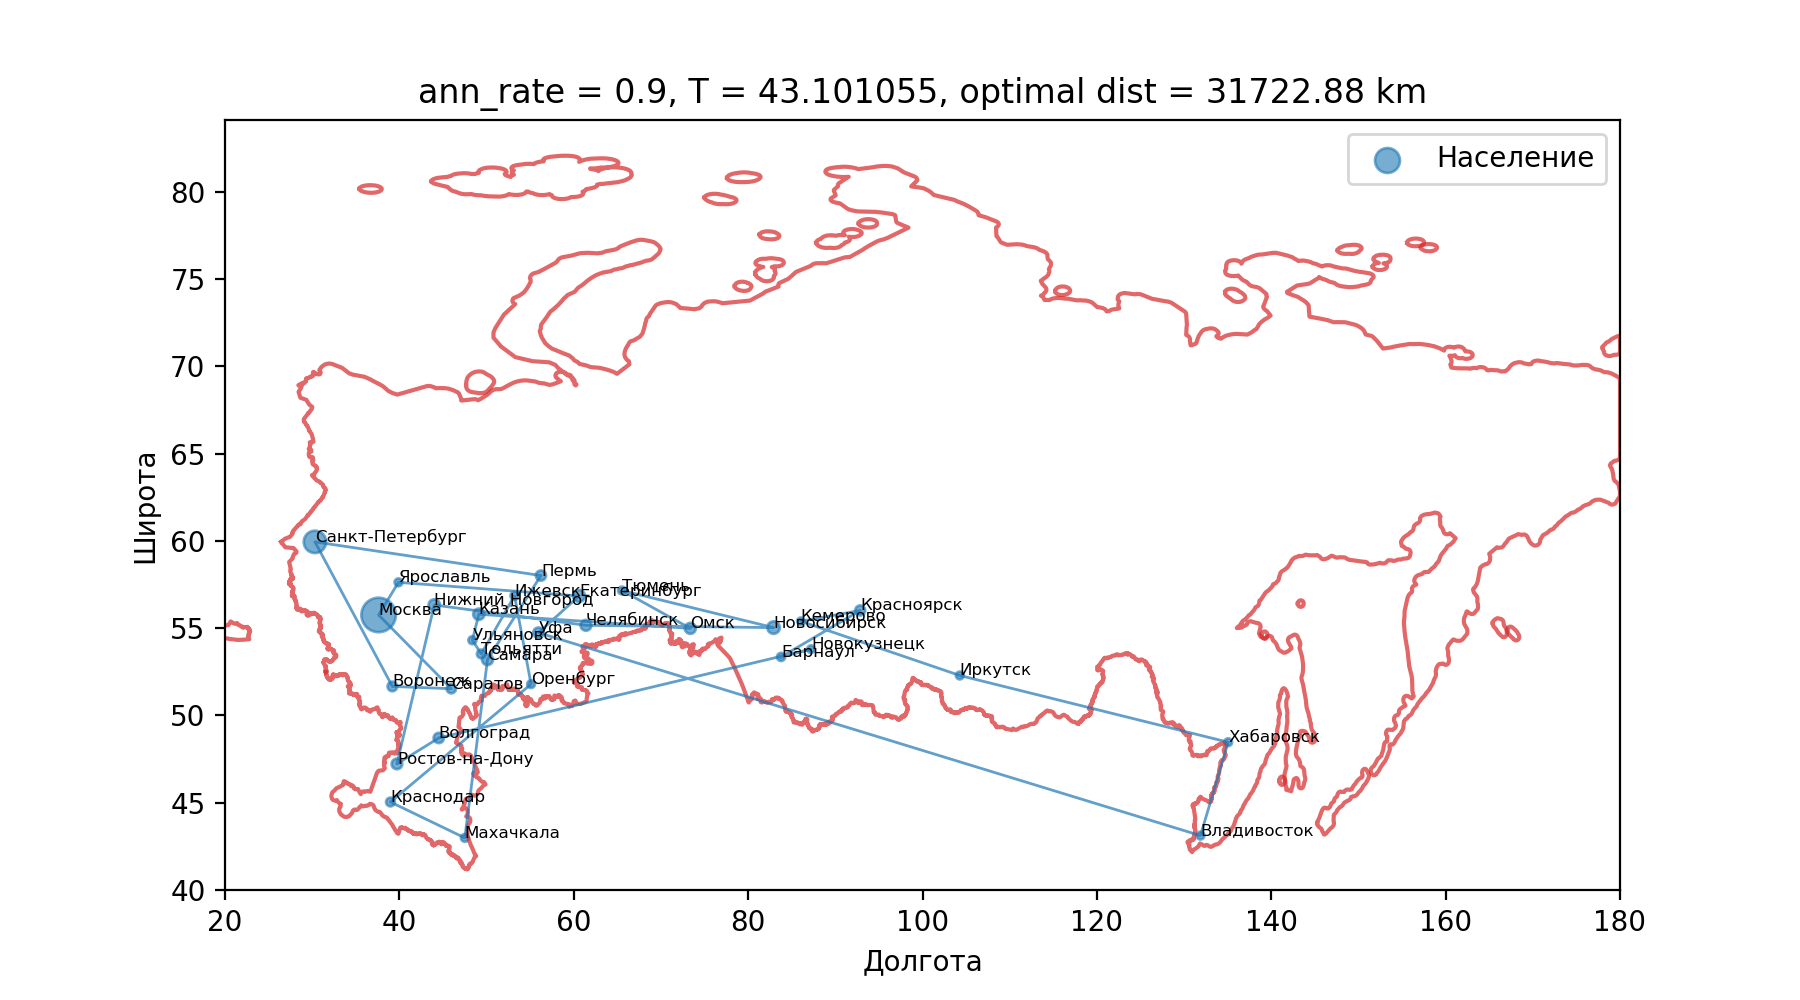

In [23]:
fig, ax = plt.subplots(figsize=(9,5))
sa_anim = CitySAAnim(ax, xs, ds, Ts, ann_rate, country=rus_data)
anim = FuncAnimation(fig, sa_anim, init_func=sa_anim.init, 
                     frames=len(ds), repeat=False,
                     save_count=1, interval=1, blit=False)

plt.show()

In [24]:
writer = FFMpegWriter(fps=40, bitrate=None)
anim.save(RESULTS_DIR + 'fast_09_country.mp4', writer=writer)

### Middle Coolling – `ann_rate = 0.95`

Running Simulated Annealing, checking convergence and showing computed optimal result.

In [25]:
np.random.seed(RANDOM_SEED)
path = np.arange(N_CITIES)
np.random.shuffle(path)

ann_rate = 0.95
xs_095, ds_095, Ts_095 = comb_sa(path, ann_rate=ann_rate)

xs, ds, Ts = xs_095.copy(), ds_095.copy(), Ts_095.copy()
len(ds), ds[-1], Ts[-1]

(377, 24951.07199632141, 33.91214677177534)

<IPython.core.display.Javascript object>


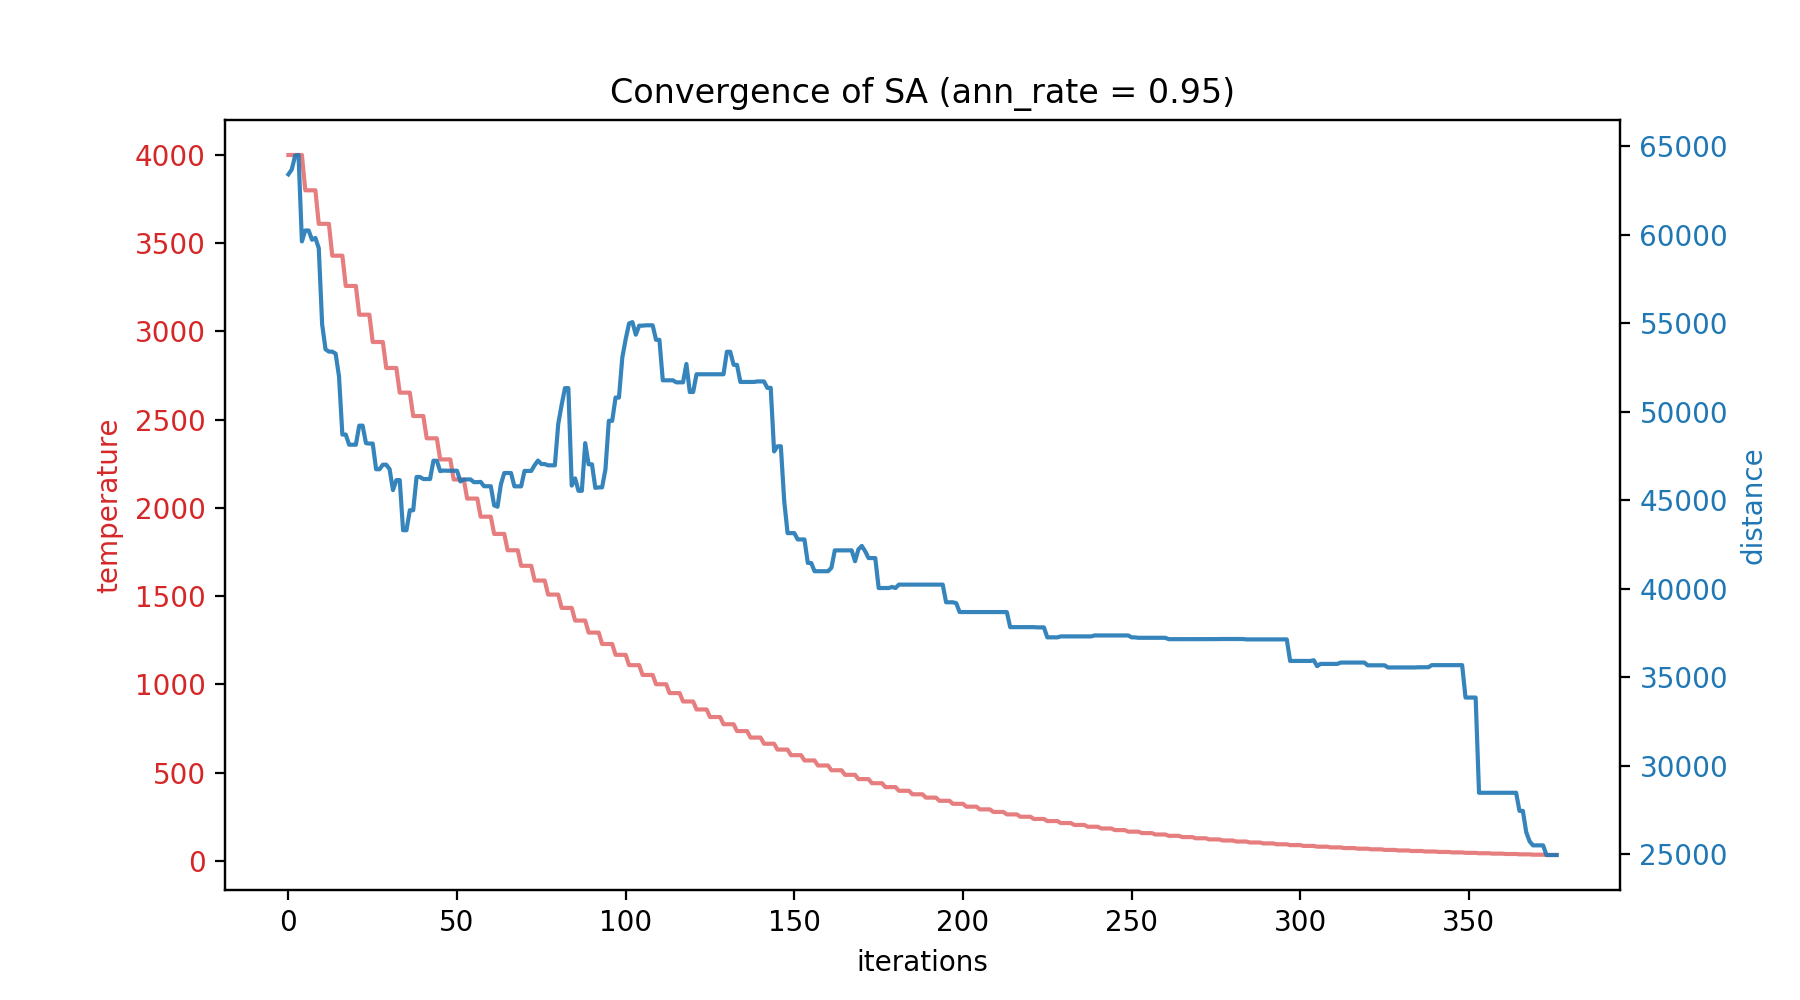

In [26]:
fig, ax = plt.subplots(figsize=(9,5))
plot_temp_dist(ax, Ts, ds, ann_rate=ann_rate)
plt.show()

<IPython.core.display.Javascript object>


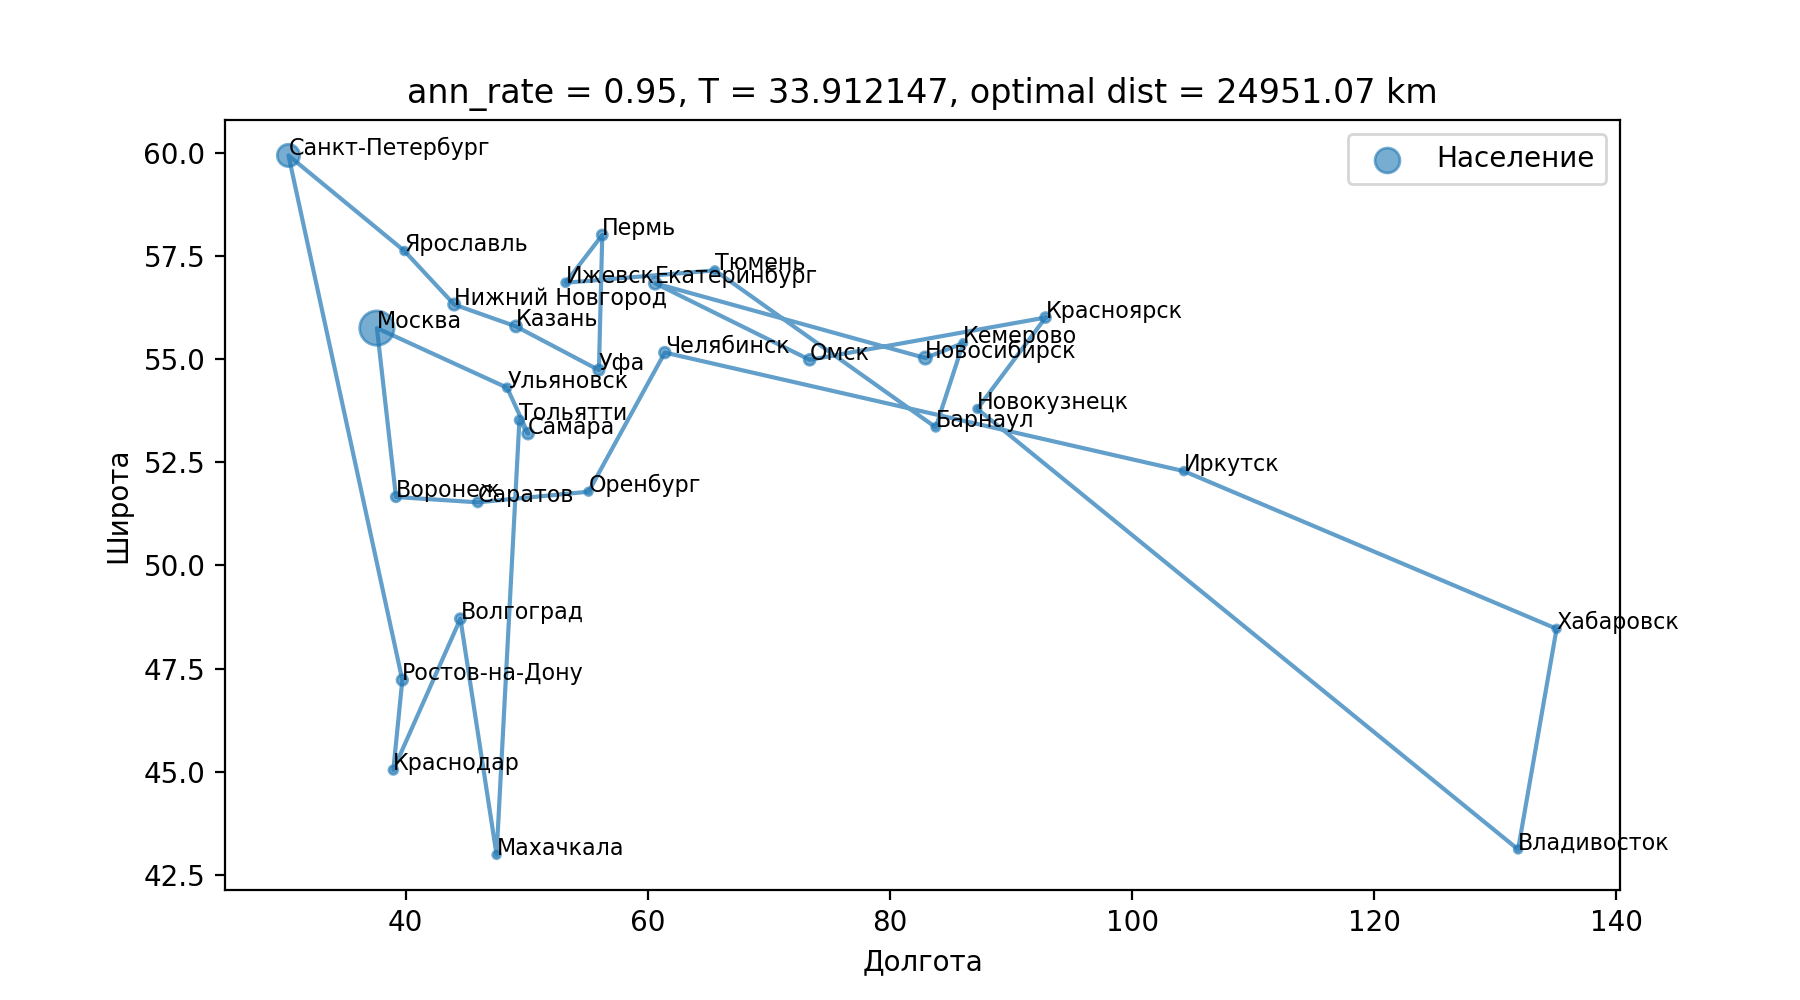

In [27]:
fig, ax = plt.subplots(figsize=(9,5))
sa_anim = CitySAAnim(ax, xs, ds, Ts, ann_rate)
anim = FuncAnimation(fig, sa_anim, init_func=sa_anim.init, 
                     frames=len(ds), repeat=False,
                     save_count=1, interval=1, blit=False)

plt.show()

In [28]:
writer = FFMpegWriter(fps=40, bitrate=None)
anim.save(RESULTS_DIR + 'mid_095.mp4', writer=writer)

<IPython.core.display.Javascript object>


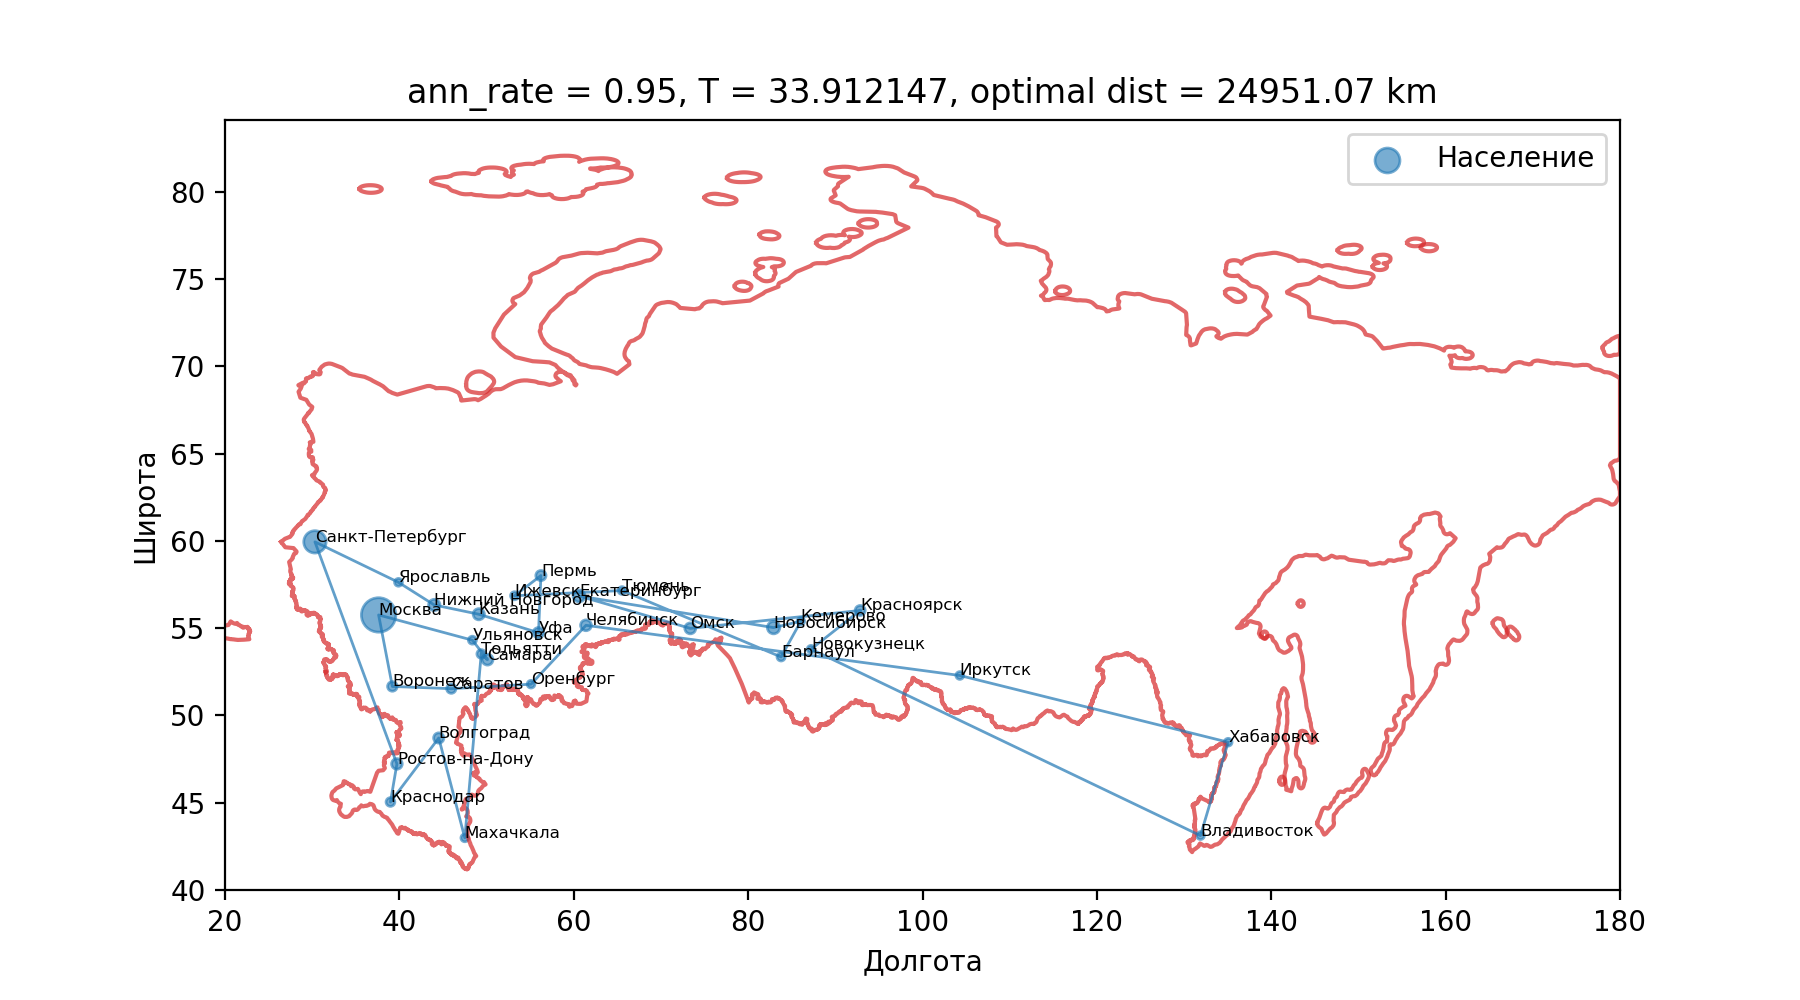

In [29]:
fig, ax = plt.subplots(figsize=(9,5))
sa_anim = CitySAAnim(ax, xs, ds, Ts, ann_rate, country=rus_data)
anim = FuncAnimation(fig, sa_anim, init_func=sa_anim.init, 
                     frames=len(ds), repeat=False,
                     save_count=1, interval=1, blit=False)

plt.show()

In [30]:
writer = FFMpegWriter(fps=40, bitrate=None)
anim.save(RESULTS_DIR + 'mid_095_country.mp4', writer=writer)

### Slow Coolling – `ann_rate = 0.99`

Running Simulated Annealing, checking convergence and showing computed optimal result.

In [31]:
np.random.seed(RANDOM_SEED)
path = np.arange(N_CITIES)
np.random.shuffle(path)

ann_rate = 0.99
xs_099, ds_099, Ts_099 = comb_sa(path, ann_rate=ann_rate)

xs, ds, Ts = xs_099.copy(), ds_099.copy(), Ts_099.copy()
len(ds), ds[-1], Ts[-1]

(2033, 18245.961745161334, 24.496478251380562)

<IPython.core.display.Javascript object>


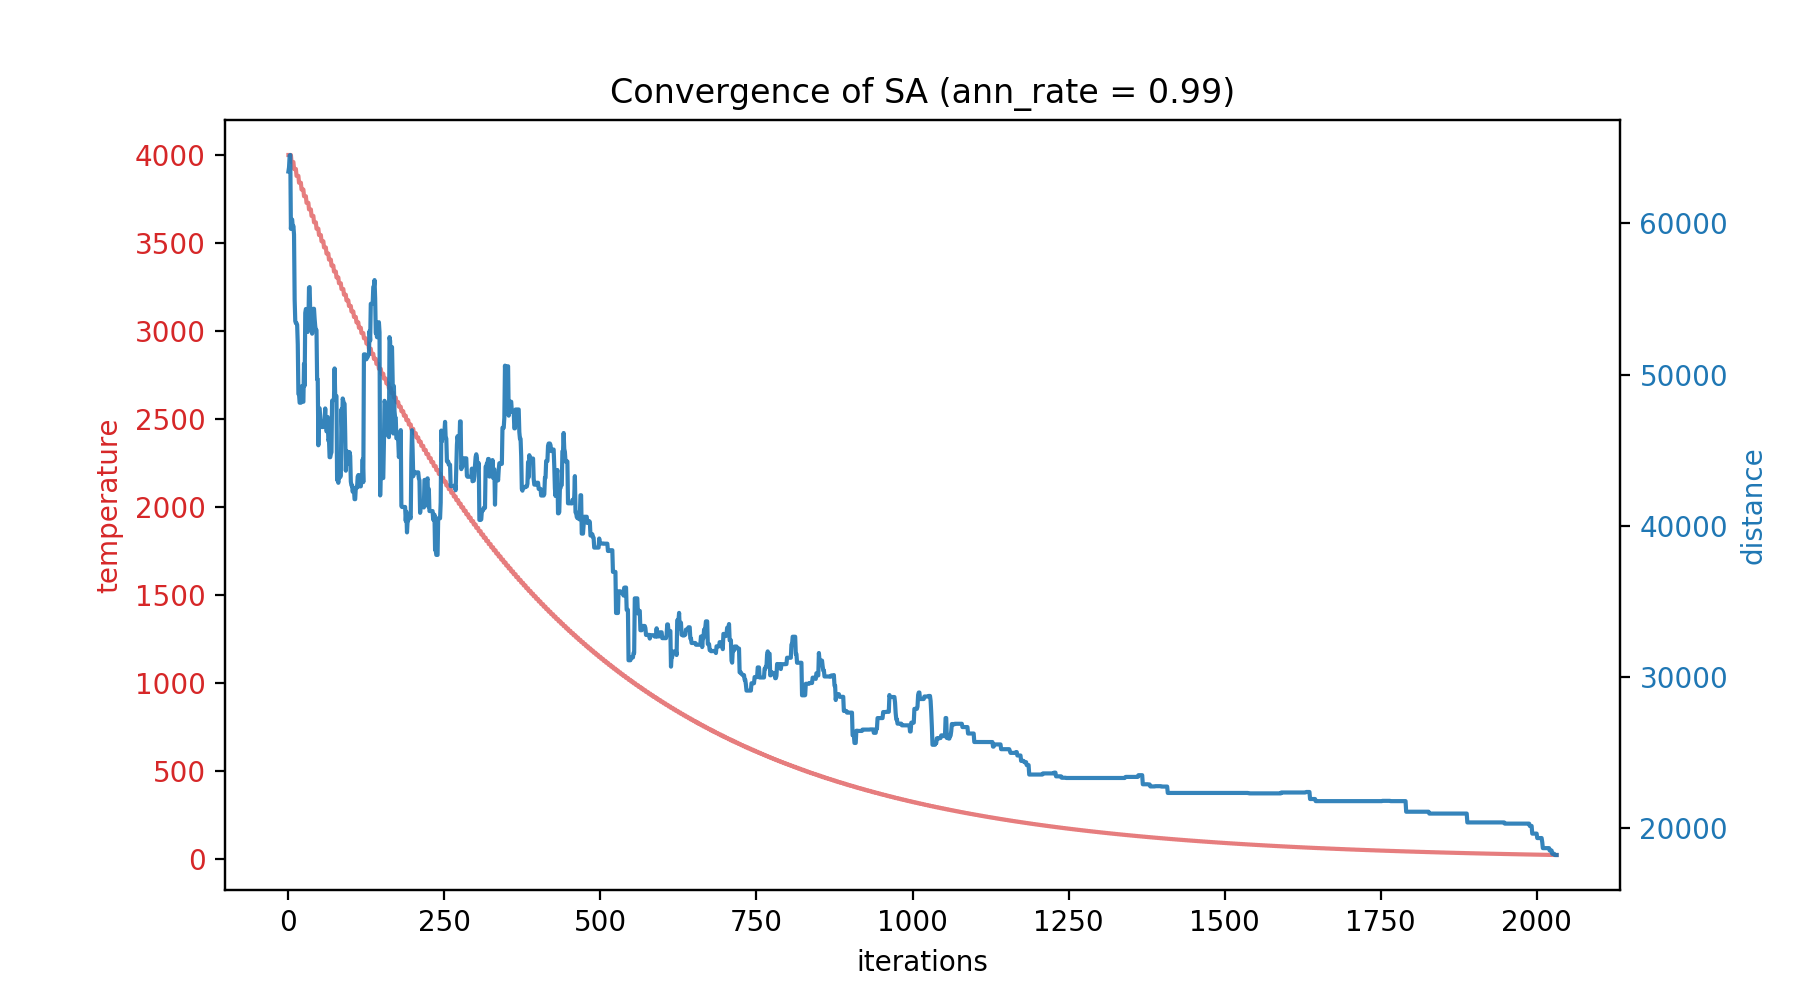

In [32]:
fig, ax = plt.subplots(figsize=(9,5))
plot_temp_dist(ax, Ts, ds, ann_rate=ann_rate)
plt.show()

<IPython.core.display.Javascript object>


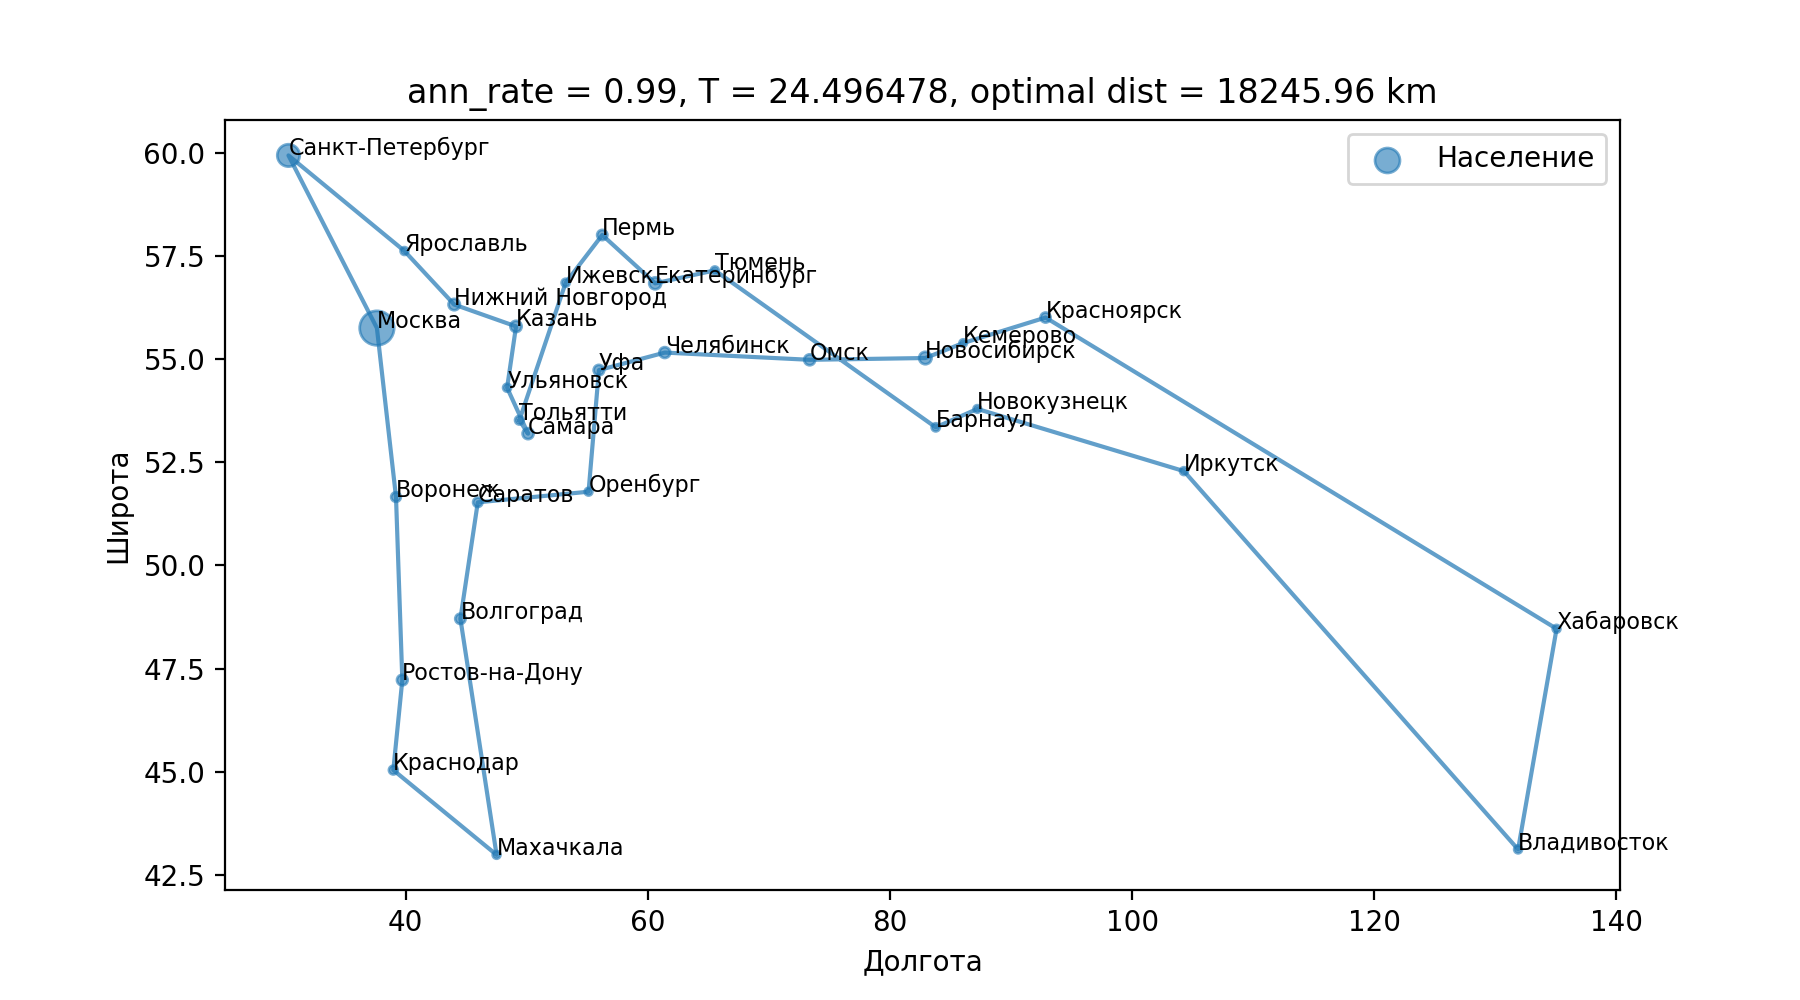

In [33]:
fig, ax = plt.subplots(figsize=(9,5))
sa_anim = CitySAAnim(ax, xs, ds, Ts, ann_rate)
anim = FuncAnimation(fig, sa_anim, init_func=sa_anim.init, 
                     frames=len(ds), repeat=False,
                     save_count=1, interval=1, blit=False)

plt.show()

In [34]:
writer = FFMpegWriter(fps=100, bitrate=None)
anim.save(RESULTS_DIR + 'slow_099.mp4', writer=writer)

<IPython.core.display.Javascript object>


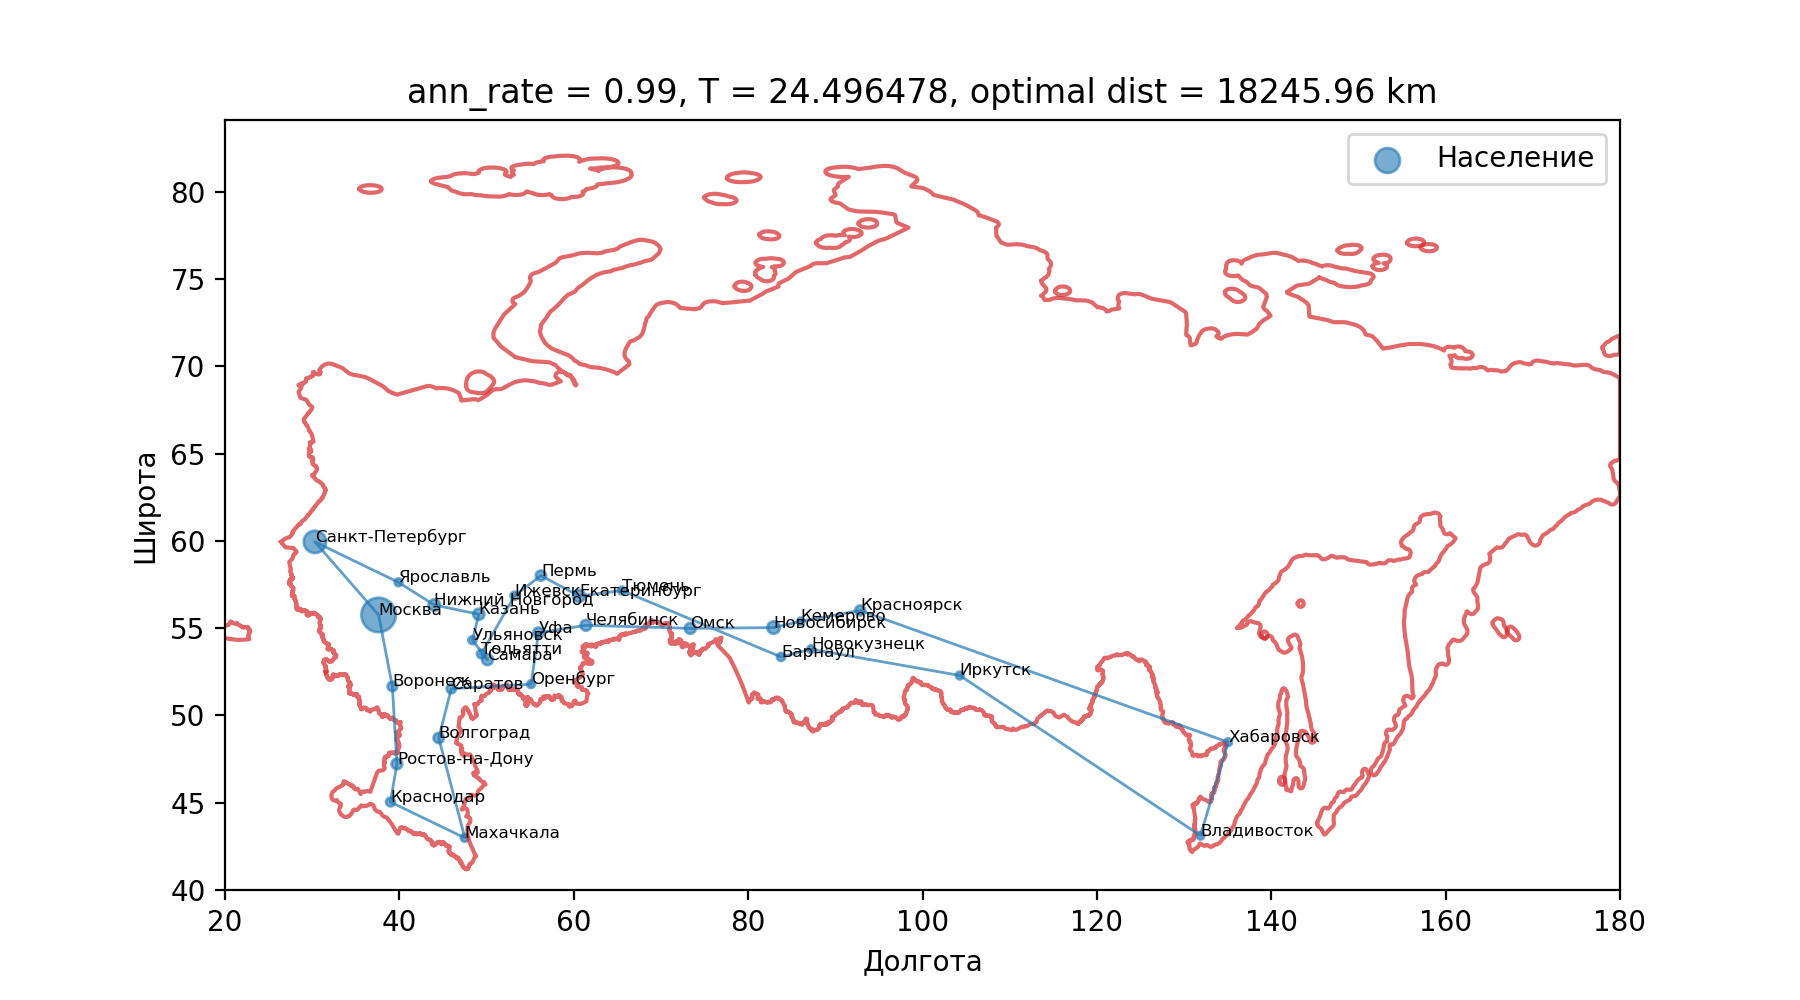

In [35]:
fig, ax = plt.subplots(figsize=(9,5))
sa_anim = CitySAAnim(ax, xs, ds, Ts, ann_rate, country=rus_data)
anim = FuncAnimation(fig, sa_anim, init_func=sa_anim.init, 
                     frames=len(ds), repeat=False,
                     save_count=1, interval=1, blit=False)

plt.show()

In [36]:
writer = FFMpegWriter(fps=100, bitrate=None)
anim.save(RESULTS_DIR + 'slow_099_country.mp4', writer=writer)

### Very slow Coolling – `ann_rate = 0.997`

Running Simulated Annealing, checking convergence and showing computed optimal result.

In [37]:
np.random.seed(RANDOM_SEED)
path = np.arange(N_CITIES)
np.random.shuffle(path)

ann_rate = 0.997
xs_0997, ds_0997, Ts_0997 = comb_sa(path, ann_rate=ann_rate)

xs, ds, Ts = xs_0997.copy(), ds_0997.copy(), Ts_0997.copy()
len(ds), ds[-1], Ts[-1]

(6813, 17908.49077290698, 24.055779692970255)

<IPython.core.display.Javascript object>


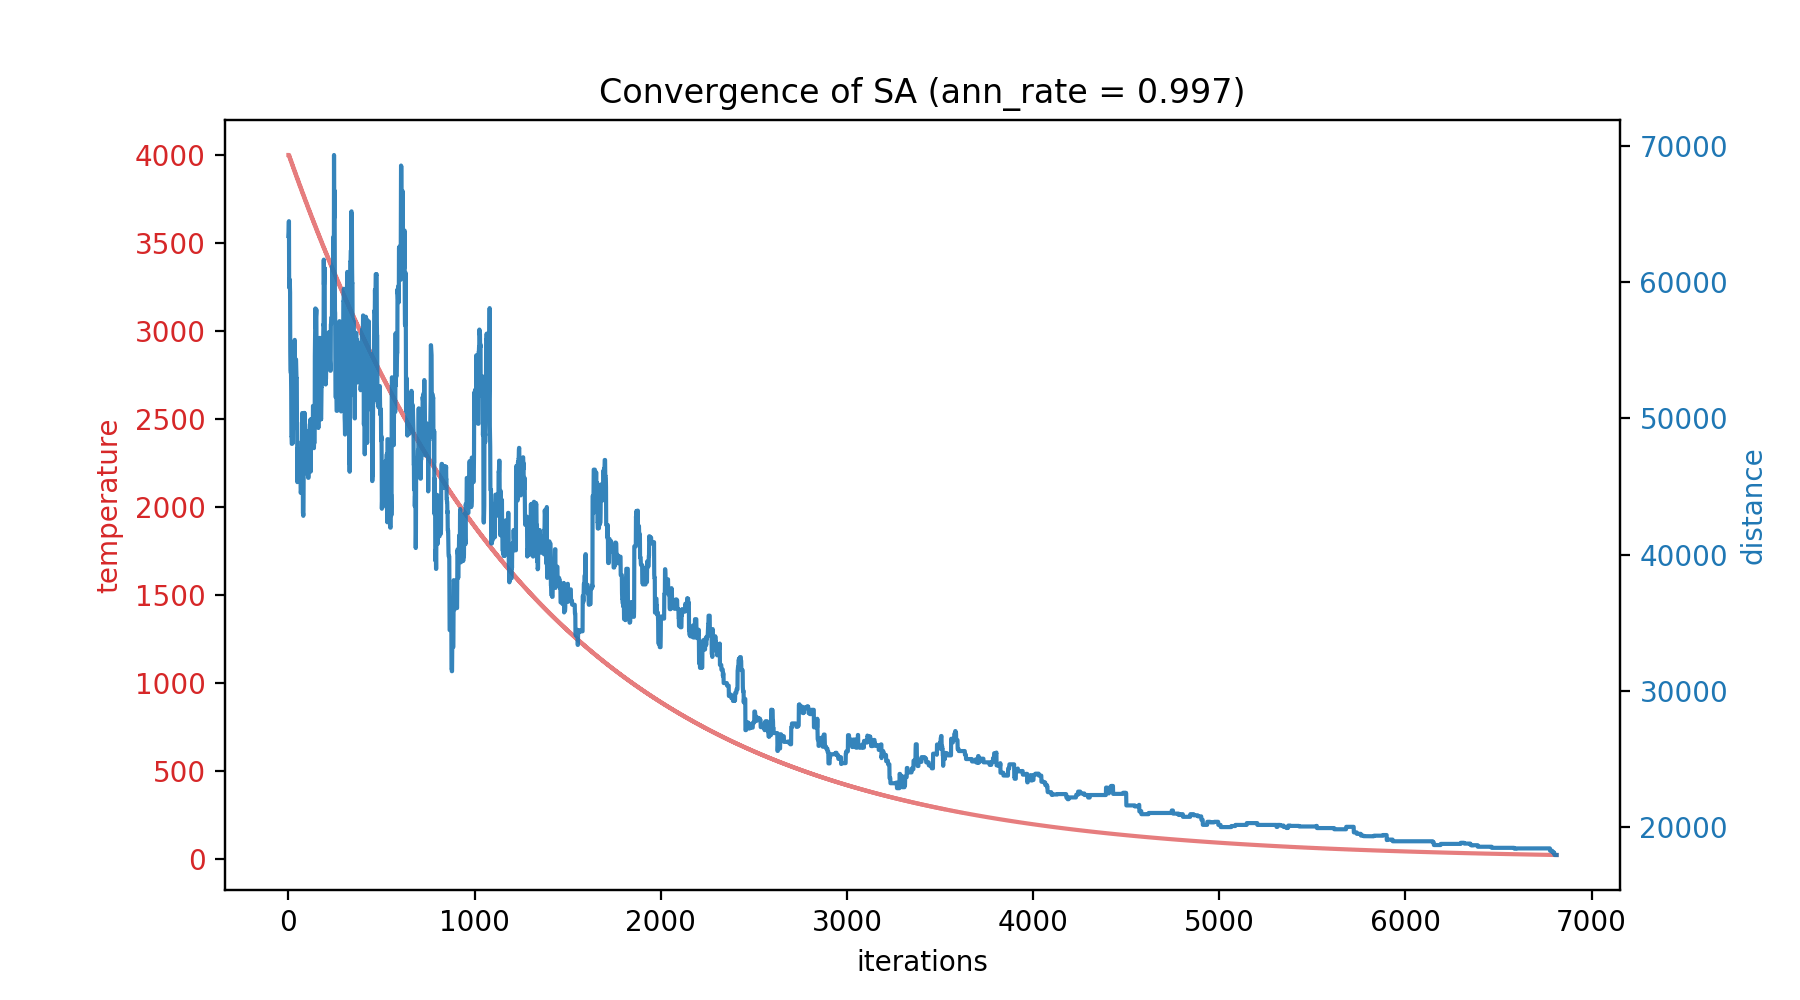

In [38]:
fig, ax = plt.subplots(figsize=(9,5))
plot_temp_dist(ax, Ts, ds, ann_rate=ann_rate)
plt.show()

<IPython.core.display.Javascript object>


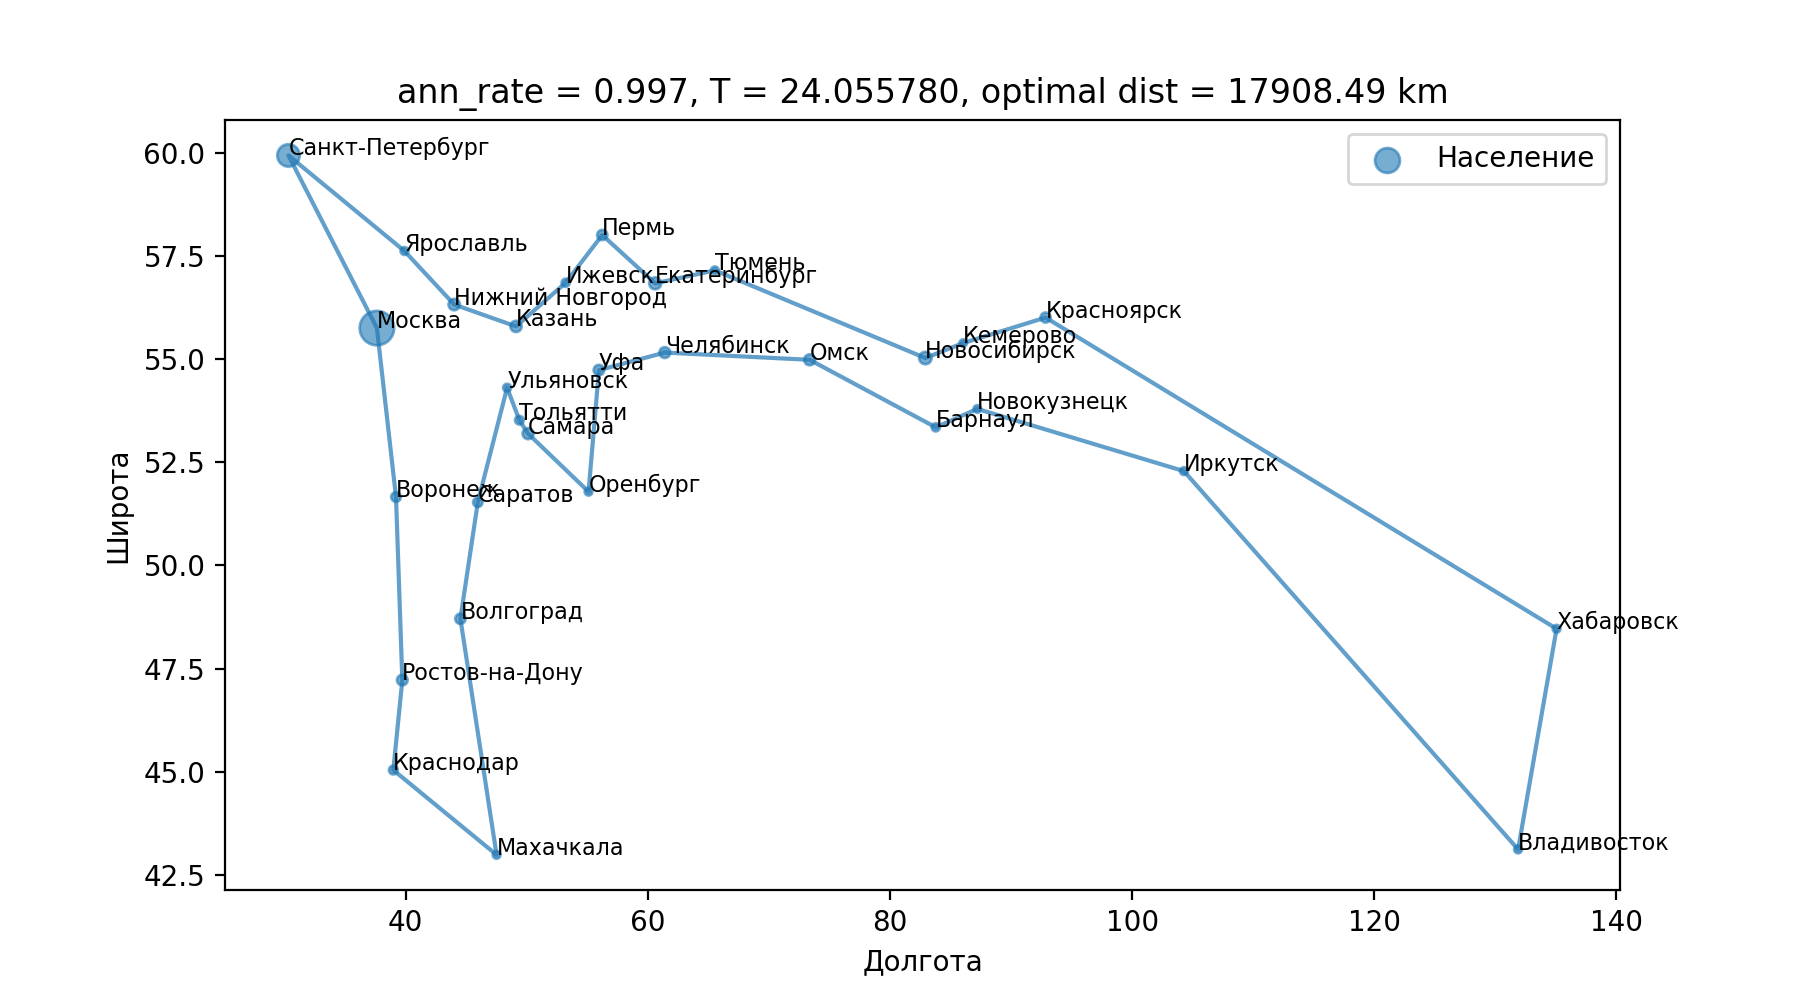

In [39]:
fig, ax = plt.subplots(figsize=(9,5))
sa_anim = CitySAAnim(ax, xs, ds, Ts, ann_rate)
anim = FuncAnimation(fig, sa_anim, init_func=sa_anim.init, 
                     frames=len(ds), repeat=False,
                     save_count=1, interval=1, blit=False)

plt.show()

In [40]:
writer = FFMpegWriter(fps=170, bitrate=None)
anim.save(RESULTS_DIR + 'slow_0997.mp4', writer=writer)

<IPython.core.display.Javascript object>


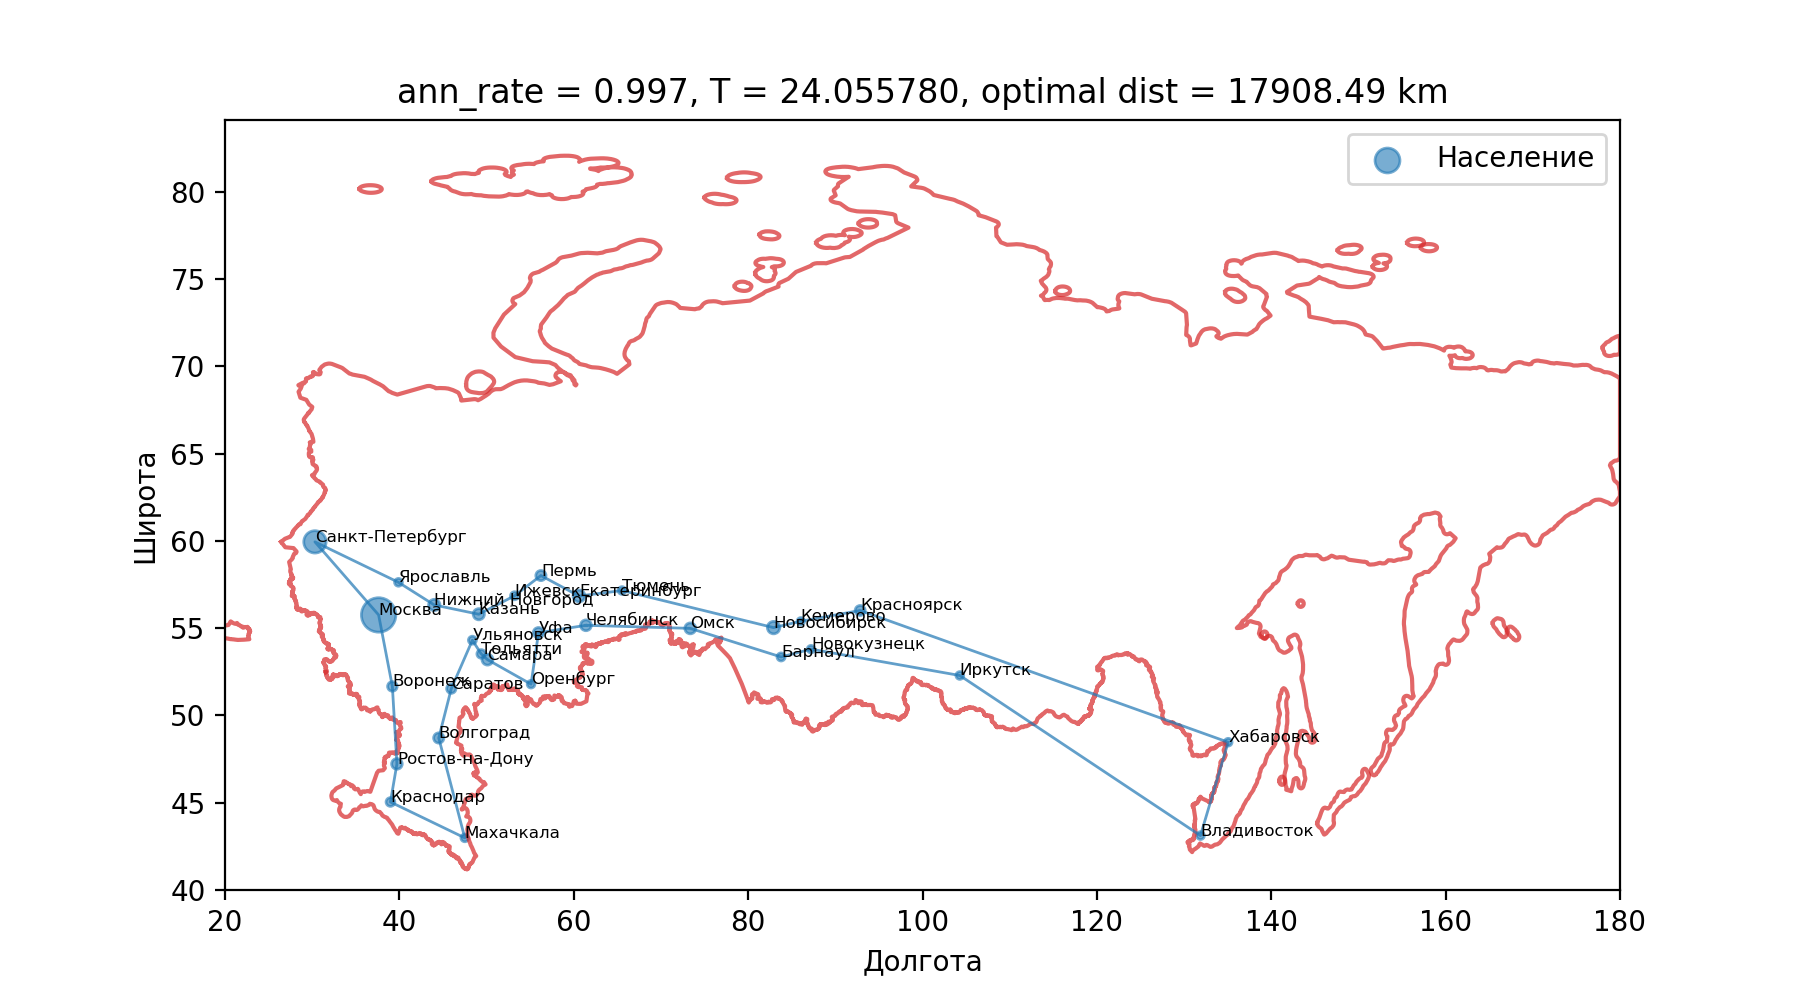

In [41]:
fig, ax = plt.subplots(figsize=(9,5))
sa_anim = CitySAAnim(ax, xs, ds, Ts, ann_rate, country=rus_data)
anim = FuncAnimation(fig, sa_anim, init_func=sa_anim.init, 
                     frames=len(ds), repeat=False,
                     save_count=1, interval=1, blit=False)

plt.show()

In [42]:
writer = FFMpegWriter(fps=170, bitrate=None)
anim.save(RESULTS_DIR + 'slow_0997_country.mp4', writer=writer)

## Convergence comparison

The first three annealing rates

<IPython.core.display.Javascript object>


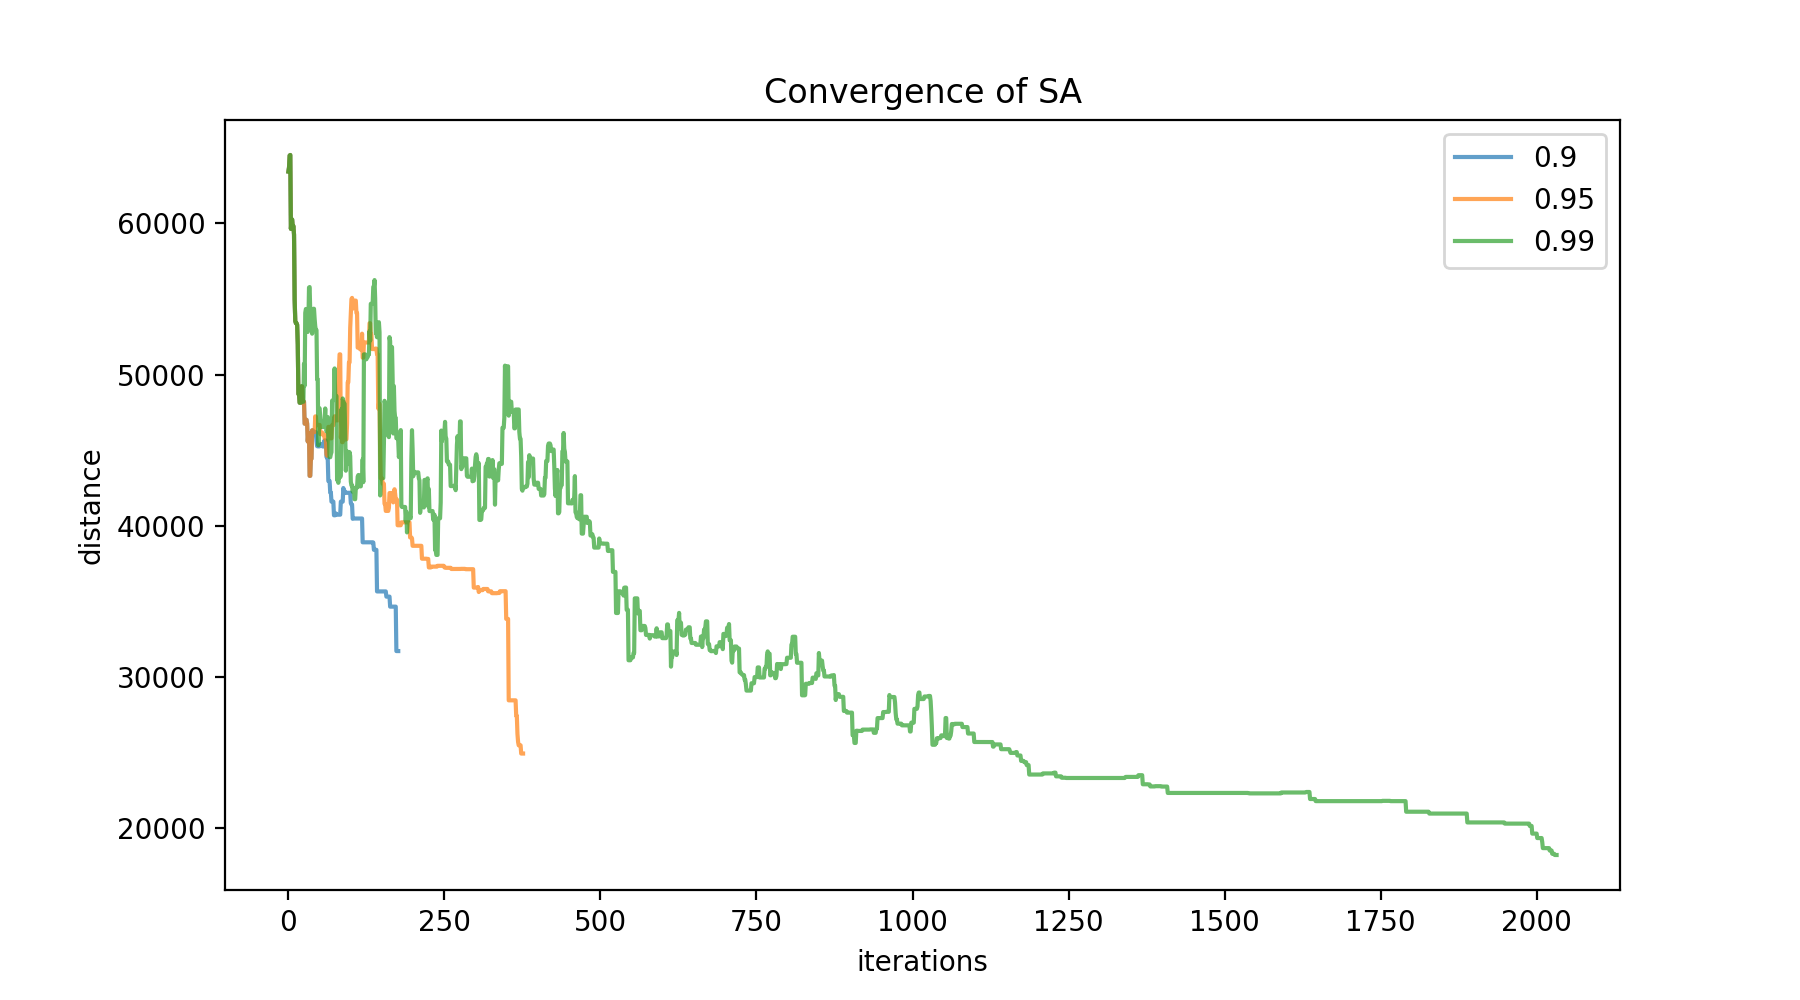

In [43]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title(f'Convergence of SA')
ax.set_xlabel('iterations')
ax.set_ylabel('distance')

ax.plot(np.arange(len(ds_09)),   ds_09,   label=0.9,   alpha=0.7)
ax.plot(np.arange(len(ds_095)),  ds_095,  label=0.95,  alpha=0.7)
ax.plot(np.arange(len(ds_099)),  ds_099,  label=0.99,  alpha=0.7)
# ax.plot(np.arange(len(ds_0997)), ds_0997, label=0.997, alpha=0.7)

ax.legend()
plt.show()

All annealing rates

<IPython.core.display.Javascript object>


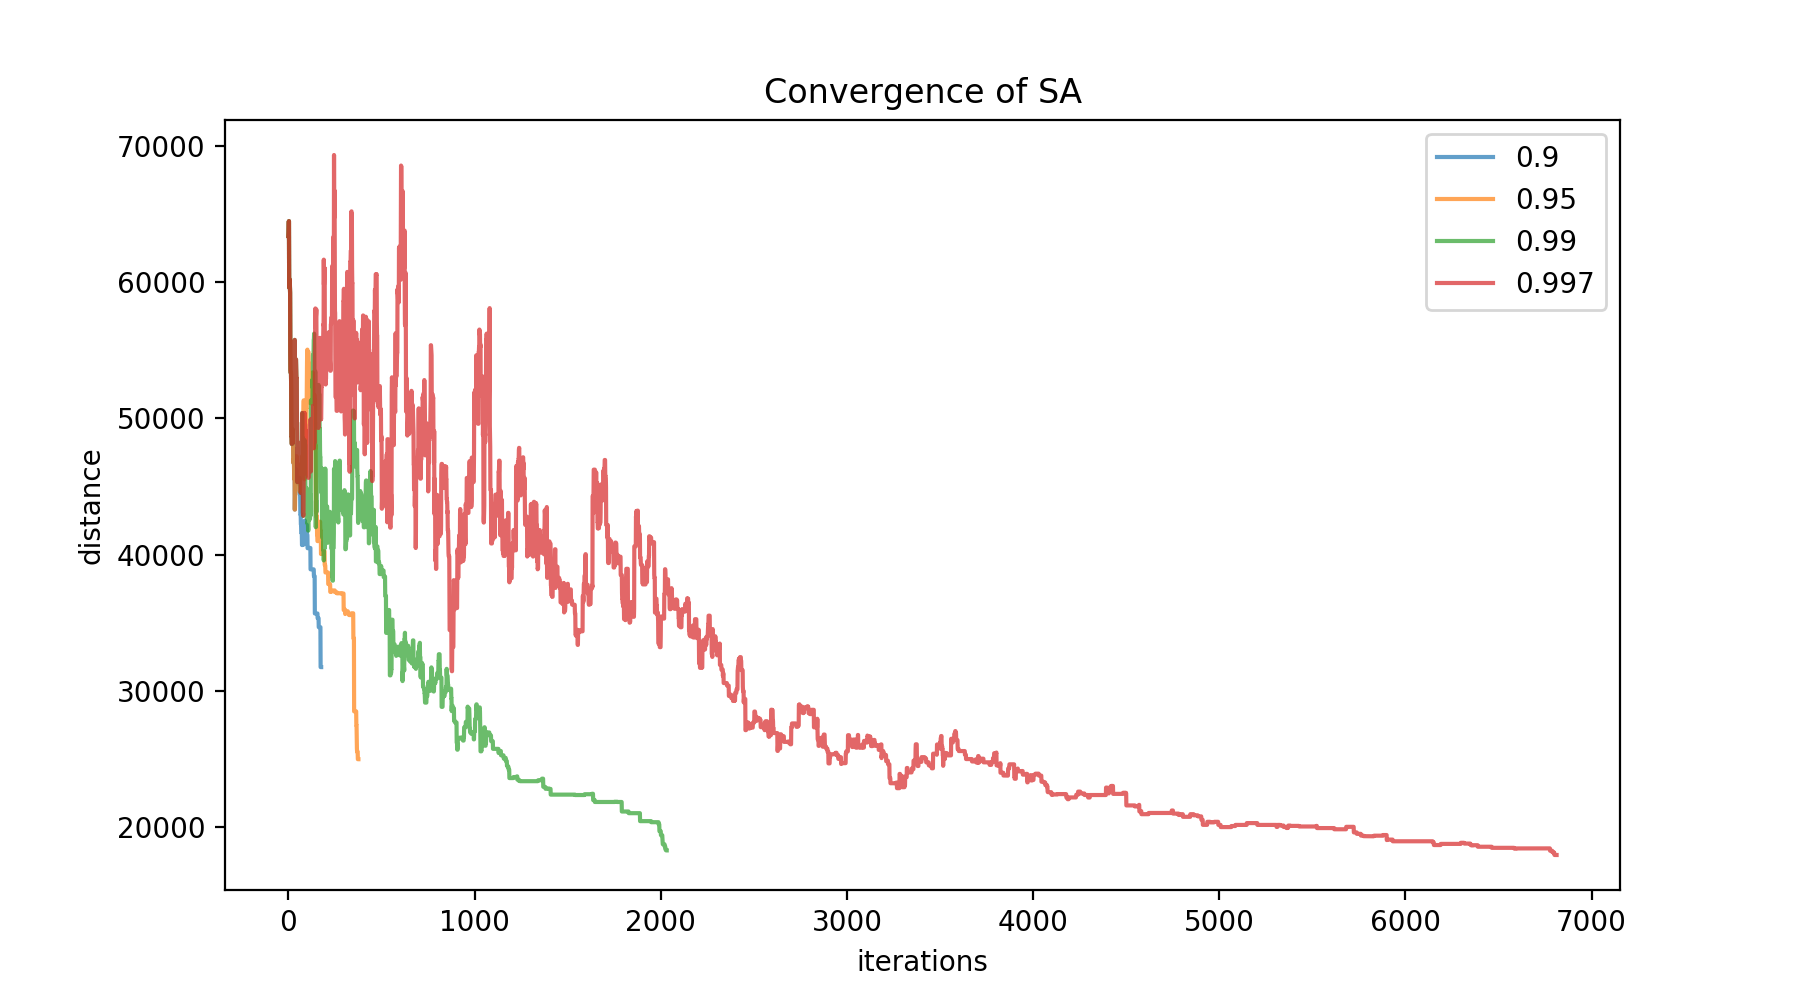

In [44]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title(f'Convergence of SA')
ax.set_xlabel('iterations')
ax.set_ylabel('distance')

ax.plot(np.arange(len(ds_09)),   ds_09,   label=0.9,   alpha=0.7)
ax.plot(np.arange(len(ds_095)),  ds_095,  label=0.95,  alpha=0.7)
ax.plot(np.arange(len(ds_099)),  ds_099,  label=0.99,  alpha=0.7)
ax.plot(np.arange(len(ds_0997)), ds_0997, label=0.997, alpha=0.7)

ax.legend()
plt.show()